In [1]:
## master stress test module: includes state macro variables:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## lists of states and banks within regional group to analyze:
## state/region:  if none: stlst=[]; if one only: stlst=['FL']; if multiple states aggregated: stlst=['FL','GA','AL']
stlst = ['FL','GA']
#stlst = ['NV']
#stlst = ['CA']
#stlst=[]

## exclusion list: (enter IDRSSD for each bank to exclude)
#exlst = []  ## use this as default
exlst = [2193616,665931,1212846]  ## FL,GA exclude: Raymond James, Northern Trust, Monogram Credit Card
#exlst = [2502656,3150447,2129008,2036843,3287660,2819167] # NV: USAA, Chas Schwab, Household (SB & NA), Toyota, Farm Bureau
if len(exlst)==0:
  exflg = ''
else:
  exflg = 'x'

#########################################################################
## Pick one of the next 5 lines:  
irflg = '_NoRates'  ## use this to remove rates from regressions
#irflg = '_NoRate_Big3'  ## SPECIAL: designates backtest re-run using only "big 3" vars: UE, HPI, CRE
#irflg = '_NoRate_Big4v'  ## SPECIAL: designates backtest re-run using only "big 4" vars: UE, HPI, CRE, CE
#irflg = ''  ## use this to keep rates in regressions and use all variables in regressions
#irflg = '_Big3' ## use this to keep rates in regressions but limit vars to Big3 only

############################################################
# 12/13/15: new list: brief list of only vars to use in regressions
#   (Note: can be a small number other than 3 if desired... like 4 or 5)
#big3 = ['UE','HPI','CRE']  ### list of big3 variables
#big3 = ['UE','HPI','CRE','VIX']  ### list of big3 vars + VIX
big3=[]  ## use this if Big3 not selected

## WARNING:  Select small group of unique banks here:
#rslst=[]  # IDRSSD list for ad hoc 
rslst = [598534]  ## Fidelity (GA)
#tclst=[]  # ticker list for ad hoc
tclst = ['CCBG']  ## Capital City (FL)

##########################################################################
##  NOTE:  Large bank exclusions:  Pick one of 3 options:
##  'x00':  Include all banks (do not exclude any)
##  'x18':  Exclude CCAR 18-bank group and their acquired/merged banks
##  'x31':  Exclude CCAR 31-bank group and their acquired/merged banks
xtyp = 'x18'  ## pick 'x00', 'x18', or 'x31' only, (with grpC18, use x00 only)

htyp = ''  # use this for ultcert tickers (to catch acquired/consolidated banks in history)
#htyp = 'nohist' # use this for current affiliates only

## group name: select one line only among choices:
## (note: only one group can be specified, but all groups will be available for further analysis later!)
## (this label will be used to name all output files to make it easy to locate them later)
#grp = 'grp' + 'TotUS_C18C31' + xtyp + exflg + htyp # special code:
#grp = 'grp' + 'TotUS' + xtyp + exflg + htyp # use this for TotUS target group
#grp = 'grp' + 'C18' + xtyp + exflg + htyp # use this for C18 target group
#grp = 'grp' + 'C31' + xtyp + exflg + htyp # use this for C31 target group
#grp = 'grp' + ''.join(stlst) + xtyp + exflg + htyp # use this for statelist (1, 2, or 3 states only)
#grp = 'grp' + 'CapFid_'+ ''.join(stlst) + xtyp + exflg + htyp # use this for any other grouping
grp = 'grp' + 'CapFid' # use this for any other grouping (fill in a unique name into blanks)

USflg = 'No'  # 'Yes' means run TotUSx00,x18,x31 groups, 'No' means do not run all 3 TotUS groups
Cxflg = 'No'  # 'Yes' means run C18x00 and C31x00 groups, 'No' means do not run both of those groups
indiv = 'Yes'  # 'Yes' means run indiv banks/tickers, 'No' means do not run indiv banks/tickers

## flags for var transforms to use: orig, lag, exp
vtyp = 2  # 0: Original vars+CE, no transformations; 1: lags (UE,HPI,CRE,CE 4q lags); 2: Lags & sUE23
qtyp = 4  # 4: rolling 4q NCO rates, 1: 1qtr NCO rates (annualized)

if qtyp == 1:
  rtyp = "1q"
  rskp = 0
  curlst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']
elif qtyp == 4:
  rtyp = "4q"
  rskp = 3
  curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
else:
  rskp = 999
  rclst = []  # force error

cbo = ['Orig', 'Lags', 'Lags_sUE2']  # descriptors for vtyp code
styp = cbo[vtyp]  # selects one of the cbo codes based on vtyp entry.

grporig = grp
grp

'grpCapFid'

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

hs['DJ'] = hs['DJ']/1000
cc['DJ'] = cc['DJ']/1000

cc2 = cc.dropna(how='any',axis=1)  # remove any vars that are missing in any ccar year (removes T5y, Prime)
cccol = list(cc2.columns)[3:]
hs2 = hs[['Date']+cccol]
hs2.set_index('Date', drop=True, inplace=True)
hs2 = hs2.ix['2000-01':]
hscol = list(hs2.columns)  # original ccar variables

In [4]:
## Tickers to exclude from aggregates: CCAR 18-bank and 31-bank groups:
c18tic = ['ALLY','AXP','BAC','BBT','BK','C','COF','FITB','GS','JPM','KEY','MS','PNC','RF','STI','STT','USB','WFC']
c31tic = c18tic + ['BMO','BBVA','CFG','CMA','DB','DFS','HSBC','HBAN','MTB','MTU','NTRS','SAN','ZION']

In [5]:
#########################################################
## section to download CE and state CE & UE variables
#########################################################

In [6]:
## prepare to gather nominal GDP from FRED database:
import pandas.io.data as web
start = pd.datetime(1976,1,1)
end = pd.datetime(2014,12,31)

In [7]:
if len(stlst) == 0:
  print("No states selected.")
else:
  print("OK to proceed.")

OK to proceed.


In [8]:
## process only if len(stlst)>0:
uestq = []
if len(stlst) > 0:
  uelst = [s + 'UR' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLUR' = FL unemp rate 
  lflst = [s + 'LF' for s in stlst]  ## codes in FRED database: 'FLLF' = FL labor force
  ## NOTE:  use labor force values as weightings for regional aggregates of state UE rates
  uest = web.DataReader(uelst+lflst,'fred',start,end)  ## download data in uest dataframe
  uest['UE_'+''.join(stlst)] = uest.apply(lambda x:np.average(x[[z+'UR' for z in stlst]],\
                                           weights=x[[z+'LF' for z in stlst]]),axis=1)
  uestq = uest.resample('Q').mean()

if len(uestq)>0:
  print(uestq.head(2))
else:
  print('No state UE')

            FLUR  GAUR     FLLF     GALF   UE_FLGA
DATE                                              
1976-03-31   9.7   8.5  3588955  2245412  9.238187
1976-06-30   9.1   8.1  3597039  2261151  8.714050


In [9]:
celst = [] # CE codes for FRED database
telst = [] # TotEmployment codes for FRED database

if len(stlst)>0: celst = [s + 'CONS' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLCE' = FL constr emp
celst = ['USCONS'] + celst
if len(stlst)>0: telst = [s + 'NA' for s in stlst]  ## FLNA is Florida total non-farm employment
telst = ['PAYEMS'] + telst
cest = web.DataReader(celst+telst,'fred',start,end)  ## download data in uest dataframe
if len(stlst)>0:
  cest[''.join(stlst)+'CONS'] = cest.apply(lambda x:np.sum(x[[z+'CONS' for z in stlst]]),axis=1)
  cest[''.join(stlst)+'NA'] = cest.apply(lambda x:np.sum(x[[z+'NA' for z in stlst]]),axis=1)
cest[['USCONS','PAYEMS']] = cest[['USCONS','PAYEMS']].astype('float')
cestq = cest.resample('Q').mean()
cestq.ix['2014']

USCONS      FLCONS      GACONS         PAYEMS         FLNA  \
DATE                                                                          
2014-03-31  6027.000000  385.266667  152.400000  137776.666667  7720.733333   
2014-06-30  6115.333333  393.600000  155.166667  138568.000000  7790.800000   
2014-09-30  6194.000000  401.200000  158.300000  139315.666667  7855.266667   
2014-12-31  6263.333333  409.100000  161.200000  140097.000000  7931.666667   

                   GANA    FLGACONS        FLGANA  
DATE                                               
2014-03-31  4090.700000  537.666667  11811.433333  
2014-06-30  4127.200000  548.766667  11918.000000  
2014-09-30  4164.000000  559.500000  12019.266667  
2014-12-31  4196.466667  570.300000  12128.133333

In [10]:
cestq['CE'] = cestq['USCONS']*100 / cestq['PAYEMS']
if len(stlst)>0: cestq['CE_'+''.join(stlst)] = cestq[''.join(stlst)+'CONS']*100 / cestq[''.join(stlst)+'NA']
cestq.tail()

USCONS      FLCONS      GACONS         PAYEMS         FLNA  \
DATE                                                                          
2013-12-31  5938.666667  377.333333  148.933333  137260.000000  7663.533333   
2014-03-31  6027.000000  385.266667  152.400000  137776.666667  7720.733333   
2014-06-30  6115.333333  393.600000  155.166667  138568.000000  7790.800000   
2014-09-30  6194.000000  401.200000  158.300000  139315.666667  7855.266667   
2014-12-31  6263.333333  409.100000  161.200000  140097.000000  7931.666667   

                   GANA    FLGACONS        FLGANA        CE   CE_FLGA  
DATE                                                                   
2013-12-31  4064.866667  526.266667  11728.400000  4.326582  4.487114  
2014-03-31  4090.700000  537.666667  11811.433333  4.374471  4.552087  
2014-06-30  4127.200000  548.766667  11918.000000  4.413236  4.604520  
2014-09-30  4164.000000  559.500000  12019.266667  4.446018  4.655026  
2014-12-31  4196.466667  570.300000  12128.133333  4.470712  4.702290

In [11]:
if 'CE' not in list(hs2.columns): 
  hs2 = hs2.merge(cestq[['CE']],how='left',left_index=True, right_index=True)
  if len(stlst)>0: 
    hs2 = hs2.merge(cestq[['CE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
    hs2 = hs2.merge(uestq[['UE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
hs2.head(2)

rGDPg      nGDPg      rDIg       nDIg        UE       CPI  \
Date                                                                       
2000-03-31  1.048548   4.306565  8.674086  12.608361  4.033333  4.017181   
2000-06-30  8.034142  10.241277  4.166088   6.015260  3.933333  3.172469   

                 T3m      T10y       BBB      Mort        DJ         HPI  \
Date                                                                       
2000-03-31  5.528730  6.670422  8.200528  8.256154  14.29618  101.617952   
2000-06-30  5.714445  6.428826  8.465758  8.310769  13.61850  104.477712   

                CRE    VIX        CE   CE_FLGA   UE_FLGA  
Date                                                      
2000-03-31  127.211  27.01  5.153673  6.263616  3.676631  
2000-06-30  123.935  33.49  5.135676  6.261704  3.721663

In [12]:
### remove all interest rate variables: (They interfere with scenario forecasts.)
xvr = ['Mort','T3m','T5y','T10y','Prime','BBB'] ## xvr: interest rate CCAR vars to exclude from regressions

### ALWAYS remove int rates for this set of regressions for CE ,CE_st and UE_st variables!!!!
cccol = [x for x in cccol if x not in xvr]  ## removes interest rate vars from cccol (ccar var columns)
cccol

['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'DJ', 'HPI', 'CRE', 'VIX']

In [13]:
## 3-var models:
## hs2, cc2 have removed T5y and Prime since those are not in CCAR 2012 or 2013 variables
hsy = hs2.copy()
hsz = hs2.copy()
hsz['Intercept'] = 1.0
hsz.reset_index(drop=False,inplace=True)
ccs = cc2.copy()
ccs.sort_index(by=['Scen','Date'],inplace=True)
ccs['Intercept'] = 1.0
svlst = [x for x in list(hs2.columns) if x not in hscol]
curlst = svlst
topn = 1  # number of final models to review (use topn=1 for production)
topx = 2  # number of 2-var pairs to allow in final 3 for 3-var models
curlst

['CE', 'CE_FLGA', 'UE_FLGA']

In [14]:
### build 3-var models:

In [15]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [16]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [17]:
# function to select topn models for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))


In [18]:
df3b.to_csv(grp+"_3var_stvar_params.csv")

In [19]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [20]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 3-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 4-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 4-var models
df4b.index = np.arange(len(df4b))


In [21]:
df4b.to_csv(grp+"_4var_stvar_params.csv")
df4b

rc   v1        r1  v2        r2   v3        r3   v4        r4  \
0       CE   UE  0.707511  DJ  0.837919  HPI  0.960899  CPI  0.961707   
1  CE_FLGA   UE  0.659356  DJ  0.823323  HPI  0.952522  CRE  0.968475   
2  UE_FLGA  VIX  0.092904  DJ  0.124135   UE  0.981745  CPI  0.983281   

        Int        c1        c2        c3        c4  
0  6.240288 -0.222385 -0.083372  0.007523  0.008669  
1  8.583541 -0.454193 -0.159714  0.023074 -0.007261  
2 -4.110435  0.035055  0.096496  1.276672  0.051692

In [22]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs[rc] = p_tot


In [23]:
ccp = ccs[ccs.Scen.isin(['Bas','Sev'])].copy()
ccp['yrscen'] = ccp.apply(lambda x: str(x['CCAR'])[-2:]+'_'+x['Scen'],axis=1)
ccp.sort_index(by=['CCAR','Scen','Date'],inplace=True)
ccp.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m   ...    \
194  2016  Sev 2018-12-31    3.9    4.9   3.1   4.4  9.1  1.6 -0.5   ...     
195  2016  Sev 2019-03-31    3.9    4.8   3.0   4.2  8.9  1.5 -0.5   ...     

     Mort       DJ    HPI    CRE   VIX  Intercept        CE   CE_FLGA  \
194   4.1  20.6409  137.7  195.4  17.6        1.0  3.545459  2.912220   
195   4.1  22.0681  138.5  198.5  16.8        1.0  3.476098  2.771065   

       UE_FLGA  yrscen  
194  10.198724  16_Sev  
195  10.047895  16_Sev  

[2 rows x 22 columns]

In [24]:
svlst

['CE', 'CE_FLGA', 'UE_FLGA']

In [25]:
cc[cc['CCAR']==2015].tail()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
149  2015  Sev 2016-12-31    3.0    4.3   1.8   3.3  9.9  1.9  0.1  0.9   1.9   
150  2015  Sev 2017-03-31    3.9    5.2   2.7   4.2  9.7  1.9  0.1  1.1   2.0   
151  2015  Sev 2017-06-30    3.9    5.2   2.8   4.1  9.5  1.7  0.1  1.2   2.1   
152  2015  Sev 2017-09-30    3.9    5.1   2.9   4.2  9.3  1.6  0.1  1.3   2.2   
153  2015  Sev 2017-12-31    3.9    5.1   3.0   4.3  9.1  1.6  0.1  1.5   2.3   

     BBB  Mort  Prime       DJ    HPI    CRE   VIX  
149  5.5   4.7    3.2  11.5214  128.4  154.6  21.6  
150  5.3   4.7    3.2  12.8947  127.9  156.1  18.7  
151  5.2   4.7    3.2  14.0792  128.4  159.6  17.6  
152  5.1   4.7    3.2  15.4303  129.5  164.0  16.4  
153  5.1   4.7    3.2  16.4876  131.0  169.1  16.5

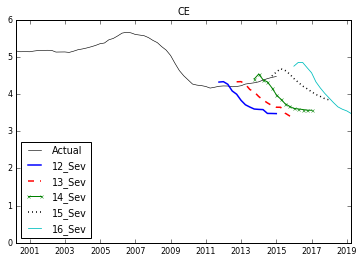

In [26]:
i = 0  ## enter 0, 1, or 2 only (for 3 items in svlst)
gr = pd.DataFrame(hsy[svlst[i]])
gr.rename(columns={svlst[i]:'Actual'},inplace=True)
cp3 = ccp[['yrscen','Date',svlst[i]]]
cp3 = cp3.pivot('Date','yrscen',svlst[i])

gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)
xa = list(gr3.index)

plt.rcParams.update({'font.size': 8})
plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
#plt.plot(xa, gr3['12_Bas'],c='b',ls=':',lw=1.3,label="12_Bas")
plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
#plt.plot(xa, gr3['13_Bas'],c='r',ls=':',lw=1.3,label="13_Bas")
plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
#plt.plot(xa, gr3['14_Bas'],c='g',ls=':',lw=1.3,label="14_Bas")
plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
#plt.plot(xa, gr3['15_Bas'],c='k',ls=':',lw=1.3,label="15_Bas")
plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
plt.title(svlst[i])
plt.ylim(ymin=0)
if svlst[i][0:2] == 'CE':
  lc = 3
else:
  lc = 2
plt.legend(loc=lc) # 2 (UE) or 3 (CE)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
svlst2 = svlst + ['UE']
svlst2.sort()
svlst2

['CE', 'CE_FLGA', 'UE', 'UE_FLGA']

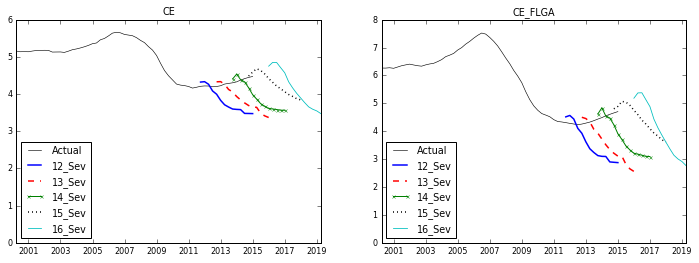

In [28]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=0  ## 0 or 2 only
for i in np.arange(2):
  plt.subplot(1, 2, i+1)
  gr = pd.DataFrame(hsy[svlst2[i+j]])
  gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
  cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
  cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

  gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

  plt.rcParams.update({'font.size': 8})
  plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
  plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
  plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
  plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
  plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
  plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
  plt.title(svlst2[i+j])
  plt.legend(loc=0)
  plt.ylim(ymin=0)

plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
"Var"+svlst2[i+j]+'_4var.png',

('VarCE_FLGA_4var.png',)

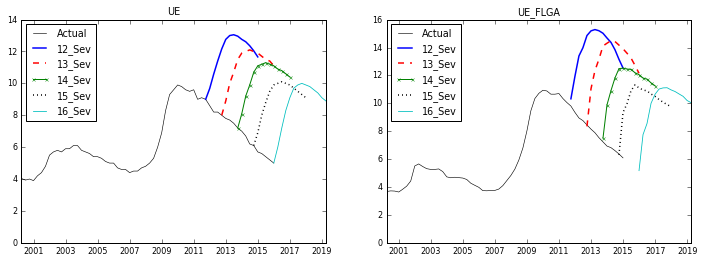

In [30]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=2  ## 0 or 2 only
if len(svlst2)==4:
  for i in np.arange(2):
    plt.subplot(1, 2, i+1)
    gr = pd.DataFrame(hsy[svlst2[i+j]])
    gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
    cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
    cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

    gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

    plt.rcParams.update({'font.size': 8})
    plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
    plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
    plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
    plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
    plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
    plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
    plt.title(svlst2[i+j])
    plt.legend(loc=0)
    plt.ylim(ymin=0)

if len(svlst2)== 4:
  plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('No output...')

In [31]:
stcol = [x for x in list(hs2.columns) if x not in list(hs.columns)]  ## list of new variables to process
stcol

['CE', 'CE_FLGA', 'UE_FLGA']

In [32]:
## add new state and CE columns to original history variable table ('hs'), call it hs3
if len(stcol)>0:
  hs3 = hs.copy()
  hs3.set_index('Date',drop=True,inplace=True)
  hs3 = hs3.ix['2000':]
  hs3 = hs3.merge(hs2[stcol],how='left',left_index=True,right_index=True)

hs3.head(2)

rGDPg      nGDPg      rDIg       nDIg        UE       CPI  \
Date                                                                       
2000-03-31  1.048548   4.306565  8.674086  12.608361  4.033333  4.017181   
2000-06-30  8.034142  10.241277  4.166088   6.015260  3.933333  3.172469   

                 T3m       T5y      T10y       BBB      Mort     Prime  \
Date                                                                     
2000-03-31  5.528730  6.586667  6.670422  8.200528  8.256154  8.686667   
2000-06-30  5.714445  6.416667  6.428826  8.465758  8.310769  9.246667   

                  DJ         HPI      CRE    VIX        CE   CE_FLGA   UE_FLGA  
Date                                                                            
2000-03-31  14.29618  101.617952  127.211  27.01  5.153673  6.263616  3.676631  
2000-06-30  13.61850  104.477712  123.935  33.49  5.135676  6.261704  3.721663

In [33]:
## add new state and CE columns to original ccar variable table ('cc'), call it cc3:
if len(stcol)>0:
  cc3 = cc.copy()
  cc3.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  cc3 = cc3.merge(ccs[['CCAR','Scen','Date']+stcol],how='left',on=['CCAR','Scen','Date'])

cc3.head(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0    ...       
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1    ...       

    BBB  Mort  Prime        DJ     HPI     CRE    VIX        CE   CE_FLGA  \
0  4.90  4.30    NaN  11.67650  137.30  177.00  48.00  4.320740  4.513751   
1  4.52  4.21    NaN  11.93609  137.21  172.17  35.97  4.270113  4.459867   

     UE_FLGA  
0  10.323391  
1  10.018211  

[2 rows x 22 columns]

In [34]:
hs3.to_csv(grp+'_histvars.csv')
cc3.to_csv(grp+'_ccarvars.csv')

In [35]:
## end of state variable (and CE) processing... move onto gathering bank data

In [36]:
## gather Call Rpt data for requested groups:

In [37]:
## process Call Rpt data for requested banks:
## rk table will be used to find identifiers (and associated acquired banks for BHCs)
if htyp == 'nohist':
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_nohist2015.csv", index_col=0)  # 20160508 nohist version
else:
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult2015.csv", index_col=0)  # 4/11/16: updated table (fixed Parentname fields)

rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
htyp

''

In [38]:
rk['C18'] = 'No'
rk['C31'] = 'No'
#c18tic
rk.loc[rk.Ticker.isin(c18tic), 'C18']='C18'
rk.loc[rk.Ticker.isin(c31tic), 'C31']='C31'

In [39]:
b18 = set(list(rk[rk['C18']=='C18']['IDRSSD']))  ## C18 banks 
b31 = set(list(rk[rk['C31']=='C31']['IDRSSD']))  ## C31 banks 

len(b18), len(b31), len(exlst)

(419, 571, 3)

In [40]:
############ CAUTION
############ CAUTION

In [41]:
## CAUTION:  DO NOT RE-RUN THIS CELL if it was run earlier in session (wastes a lot of time)
## read Call Report extract file for all banks:
dg2 = pd.read_csv("df2_2001_2015.csv")
dg2['AsOf'] = pd.to_datetime(dg2['AsOf'])

fcol = dg2.columns[5:]  ## get listing of numeric fields, then...
dg2[fcol] = dg2[fcol].astype(float)  ### CRITICAL to convert numeric data to FLOAT!!! (since some are ints)

In [42]:
dcol = list(dg2)[5:]  ## data column names
dcol[0:5]

['Cert', 'eTotAst', 'eTotLn', 'eALLL', 'eOREO']

In [43]:
## grpTotUSx00:
px00 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px00 = dg2[['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px00n = dg2[['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px00n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px00 = px00.merge(px00n,how='left',left_index='True',right_index='True')
  px00 = px00.reset_index(drop=False)
  px00['IDRSSD'] = 0
  px00['Grp'] = 'grp' + 'TotUS' + 'x00' + htyp
  px00 = px00[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px00)

0

In [44]:
## grpTotUSx18:
px18 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px18 = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px18n = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px18 = px18.merge(px18n,how='left',left_index='True',right_index='True')
  px18 = px18.reset_index(drop=False)
  px18['IDRSSD'] = 0
  px18['Grp'] = 'grp' + 'TotUS' + 'x18' + htyp
  px18 = px18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px18)

0

In [45]:
## grpTotUSx31:
px31 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px31 = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px31n = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px31 = px31.merge(px31n,how='left',left_index='True',right_index='True')
  px31 = px31.reset_index(drop=False)
  px31['IDRSSD'] = 0
  px31['Grp'] = 'grp' + 'TotUS' + 'x31' + htyp
  px31 = px31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px31)

0

In [46]:
#C18 processing:
pcx18=[]
if ('C18' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx18 = dg2[dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx18n = dg2[dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx18 = pcx18.merge(px18n,how='left',left_index='True',right_index='True')
  pcx18 = pcx18.reset_index(drop=False)
  pcx18['IDRSSD'] = 0
  pcx18['Grp'] = 'grpC18x00'
  pcx18 = pcx18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx18)

0

In [47]:
# C31 processing:
pcx31=[]
if ('C31' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx31 = dg2[dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx31n = dg2[dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx31 = pcx31.merge(px31n,how='left',left_index='True',right_index='True')
  pcx31 = pcx31.reset_index(drop=False)
  pcx31['IDRSSD'] = 0
  pcx31['Grp'] = 'grpC31x00'
  pcx31 = pcx31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx31)

0

In [48]:
## state level aggregates: # 20160414:  run x00
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
pxstx00 = []
if len(stlst)>0:
  xt = 'x00'
  stx = []
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  if len(stx)==0: strs = [x for x in strs]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pxst.merge(pxstn,how='left',left_index='True',right_index='True')
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx00 = pxst.copy()

len(pxstx00)

60

In [49]:
stlst

['FL', 'GA']

In [50]:
## state level aggregates: # 20160414:  run x18x
pxstx18x=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0)&(exflg=='x'):
  xt = 'x18'
  stx = list(b18) + exlst
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pxst.merge(pxstn,how='left',left_index='True',right_index='True')
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + exflg + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18x = pxst.copy()

len(pxstx18x)

60

In [51]:
## state level aggregates: # 20160414:  run x18
pxstx18=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0):
  xt = 'x18'
  stx = list(b18) 
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pxst.merge(pxstn,how='left',left_index='True',right_index='True')
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt  + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18 = pxst.copy()

len(pxstx18)

60

In [52]:
prd='eTotLn'
dgp5=[]

if len(stlst)>0:
  dgp = dg2[(dg2[prd]>0)&(dg2.State.isin(stlst))][['IDRSSD','Name','AsOf',prd]]
  dgp.sort_index(by=['IDRSSD',prd],ascending=[True,False],inplace=True)

  dgp.sort_index(by=['IDRSSD','AsOf'],inplace=True)
  dgp5 = dgp.ix[dgp.groupby(['IDRSSD']).apply(lambda x: x[prd].idxmax())]
  dgp5 = dgp5.merge(rk[['IDRSSD','Ticker','C18','C31','xState','xCert','xAsOf']],how='left',on='IDRSSD')
  dgp5.sort_index(by=[prd],ascending=False,inplace=True)
  dgp5.to_csv(grp+"_"+prd+"_maxbal.csv")

if len(dgp5)>20: dpg5=dgp5[0:20]
    
dgp5

IDRSSD                                         Name       AsOf  \
289   675332                                SUNTRUST BANK 2015-12-31   
544  2735146                                     EVERBANK 2015-12-31   
180   395238                                 SYNOVUS BANK 2010-06-30   
856  3938186                               BANKUNITED, NA 2015-12-31   
450  1442380                         UNIVERSAL BANK, N.A. 2001-09-30   
475  2193616                       RAYMOND JAMES BANK, NA 2015-12-31   
286   665931                           NORTHERN TRUST, NA 2010-12-31   
638  2962652                  BANK OF AMERICA GEORGIA, NA 2004-03-31   
418  1212846                    MONOGRAM CREDIT CARD BANK 2003-06-30   
505  2578240                FIRST UNION DIRECT BANK, N.A. 2003-09-30   
396  1017939                        UNITED COMMUNITY BANK 2015-09-30   
45     83638                    MERCANTIL COMMERCEBANK NA 2015-12-31   
859  4160667                     CAPITAL BANK CORPORATION 2015-12-31   
858  4041421                   FLORIDA COMMUNITY BANK, NA 2015-12-31   
345   832377                        BANK OF NORTH GEORGIA 2008-12-31   
284   663834                                   OCEAN BANK 2006-06-30   
340   814430                CITY NATIONAL BANK OF FLORIDA 2015-12-31   
431  1396652                              MERCANTILE BANK 2007-06-30   
317   764030                                  AMERIS BANK 2015-12-31   
433  1401529               FIRST NATIONAL BANK OF FLORIDA 2004-12-31   
30     53033                     SABADELL UNITED BANK, NA 2015-12-31   
256   598534                                FIDELITY BANK 2015-12-31   
802  3550131                   WACHOVIA CARD SERVICES, NA 2009-12-31   
857  3967449                    COMMUNITY & SOUTHERN BANK 2015-12-31   
799  3536407                                  USAMERIBANK 2015-12-31   
52    101233           RIVERSIDE NATIONAL BANK OF FLORIDA 2007-12-31   
468  1929247              CENTERSTATE BANK OF FLORIDA, NA 2015-12-31   
533  2689463                          BB&T FINANCIAL, FSB 2012-12-31   
165   347572                                 BANKATLANTIC 2012-03-31   
752  3384318                 STATE BANK AND TRUST COMPANY 2015-12-31   
..       ...                                          ...        ...   
709  3266487                    FLINT RIVER NATIONAL BANK 2008-06-30   
54    102333                        WILKINSON COUNTY BANK 2010-09-30   
259   610539                          BANK OF EDISON, THE 2001-06-30   
244   563934      FIRST NATIONAL BANK OF CHATTOOGA COUNTY 2005-06-30   
116   226734                           PEOPLES STATE BANK 2006-03-31   
590  2845166                            BANCO POPULAR, NA 2003-06-30   
106   205430                                CITIZENS BANK 2003-12-31   
75    145835                      NET FIRST NATIONAL BANK 2001-09-30   
253   581237                            BANK OF PENSACOLA 2015-12-31   
241   555836                    SYLVESTER BANKING COMPANY 2001-03-31   
337   808037                             PANAMERICAN BANK 2001-09-30   
25     34836                WOODBURY BANKING COMPANY, THE 2009-12-31   
855  3929812                  SILVERTON BRIDGE BANK, N.A. 2009-06-30   
186   413570                         LIBERTY BANK & TRUST 2002-06-30   
374   959630                          BANK OF LUMBER CITY 2005-09-30   
44     83236                            BANK OF THE SOUTH 2014-12-31   
12     14931                           FIRST WESTERN BANK 2003-03-31   
265   615776  ELBERTON FEDERAL SAVINGS & LOAN ASSOCIATION 2015-12-31   
217   501039              GREENVILLE BANKING COMPANY, THE 2009-03-31   
281   649632                          ROCHELLE STATE BANK 2011-09-30   
624  2914820                           RBC BANK (GEORGIA) 2008-06-30   
576  2808723                           BELK NATIONAL BANK 2002-03-31   
390  1007734                      BARWICK BANKING COMPANY 2002-12-31   
473  2111508            SOUTHBANK, A FEDERAL S

In [53]:
# process requested tickers and IDRSSDs:
pxbk = []
if (len(tclst)>0)&(indiv=='Yes'):
  bkrs=rslst+list(rk[rk['Ticker'].isin(tclst)]['IDRSSD'])
  bknm=list(rk[rk['IDRSSD'].isin(bkrs)]['xName'])
  pxbk = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxbkn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxbkn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxbk = pxbk.merge(pxbkn,how='left',left_index='True',right_index='True')
  pxbk = pxbk.reset_index(drop=False)
  pxbk['IDRSSD'] = 0
  pxbk['Grp'] = grp
  pxbk = pxbk[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pxbk), grp

(60, 'grpCapFid')

In [54]:
# rslst processing:
pxri = []
if (len(rslst)>0)&(indiv=='Yes'):
  for i in np.arange(len(rslst)):
    bknm=rk[rk['IDRSSD']==rslst[i]]['xName']
    pxrj = dg2[dg2['IDRSSD']==rslst[i]][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxrjn = dg2[dg2['IDRSSD']==rslst[i]][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxrjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxrj = pxrj.merge(pxrjn,how='left',left_index='True',right_index='True')
    pxrj = pxrj.reset_index(drop=False)
    pxrj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()]) + str(i)
    pxrj['IDRSSD'] = rslst[i]
    pxrj = pxrj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxri = pxrj.copy()
    else:
      pxri = pd.concat([pxri,pxrj],ignore_index=True)

len(pxri)

60

In [55]:
# tclst processing:  ## 20160505: handles multiple tickers in tclst!!
pxci = []
if (len(tclst)>0)&(indiv=='Yes'):
  # create dict for ParRSSD:
  tcd = dict([(i, x) for i, x in zip(rk[rk.Ticker.isin(tclst)].Ticker, rk.ParRSSD)])
  for i in np.arange(len(tclst)):
    bkrs=list(rk[rk['Ticker'].isin([tclst[i]])]['IDRSSD'])
    bknm=(rk[rk['IDRSSD']==bkrs[i]]['Parent'])
    pxcj = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxcjn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxcjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxcj = pxcj.merge(pxbkn,how='left',left_index='True',right_index='True')
    pxcj = pxcj.reset_index(drop=False)
    pxcj['IDRSSD'] = tcd[tclst[i]]
    pxcj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()[0:3]]) + str(i)
    pxcj = pxcj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxci = pxcj.copy()
    else:
      pxci = pd.concat([pxci,pxcj],ignore_index=True)

len(pxci)

60

In [56]:
pxlst = [px00,px18,px31,pcx18,pcx31,pxstx00,pxstx18,pxstx18x,pxbk,pxri,pxci]
pxz = pd.concat([x for x in pxlst if len(x)>0])
gpxz = list(pxz[['Grp','AsOf']].groupby('Grp').count().index)
len(pxz), gpxz

(360,
 ['grpCapCitBan0',
  'grpCapFid',
  'grpFIDBAN0',
  'grpFLGAx00',
  'grpFLGAx18',
  'grpFLGAx18x'])

In [57]:
pxz[['Grp','nbr']].groupby('Grp').count()

nbr
Grp               
grpCapCitBan0   60
grpCapFid       60
grpFIDBAN0      60
grpFLGAx00      60
grpFLGAx18      60
grpFLGAx18x     60

In [58]:
pxz2 = pxz[['Grp','nbr']].groupby('Grp').mean()
pxz2

nbr
Grp                      
grpCapCitBan0    2.783333
grpCapFid        2.783333
grpFIDBAN0       1.000000
grpFLGAx00     528.450000
grpFLGAx18     509.166667
grpFLGAx18x    507.916667

In [59]:
grplst = list(pxz2.index)
grplst

['grpCapCitBan0',
 'grpCapFid',
 'grpFIDBAN0',
 'grpFLGAx00',
 'grpFLGAx18',
 'grpFLGAx18x']

In [60]:
## set up processing tables for calcs:
df3 = pxz.copy()  # set up for calc processing using old table names
df3.sort_index(by=['Grp','IDRSSD','AsOf'],inplace=True)  ## added 12/24/15

df3['mn'] = df3['AsOf'].map(lambda x: x.month)  ## add separate month col to ease calcs converting YTDs to qtrly vals

df3a = df3[['Grp','IDRSSD','AsOf','mn']]  # table used to run calcs
df3z = df3[['Grp','IDRSSD','AsOf']]  # table to hold calc results

In [61]:
dct = { 3 : 0, 6 : 1/2 , 9 : 2/3, 12 : 3/4 }

# fn to adjust 1st row of each bank... 
# modified to use dict "dct" to speed processing:
def qa(x):
  if x['mn'] == 3: return 0
  if pd.isnull(x['x_1']):
    return dct[x['mn']] * x['x']
  else: 
    return x['x_1']

def q_calc(xi, xc):
  # calc Call Data into quarterly values from YTD values
  df3a['x'] = df3[xi]
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xi].shift(1)
  df3a['x_1'] = df3a.apply(qa, axis=1)
  df3a['xq'] = df3a['x'] - df3a['x_1']
  df3z[xc] = df3a['xq']
  return

In [62]:
q_calc('isNetInc', 'qNetInc')
q_calc('iiNetII', 'qNetII')
q_calc('isProv', 'qProv')
q_calc('isTotNII', 'qNonII')
q_calc('isTotNIE', 'qNonIE')
q_calc('isOREOgl', 'qOREOgl')    # 20160501
q_calc('isIntangExp', 'qIntangExp')

df3z['qRev'] = df3z['qNetII'] + df3z['qNonII']
df3z['qCashExp'] = df3z['qNonIE'] - df3z['qIntangExp']

q_calc('iiTotII', 'qiTotII')  # 20160320
q_calc('iiTotLn', 'qiTotLn')
q_calc('iiRE', 'qiRE')
q_calc('iiCI', 'qiCI')
q_calc('iiCard', 'qiCard')
q_calc('iiOthCsmr', 'qiOthCsmr')
q_calc('iiLeas','qiLeas')

df3z['qiTotLnLs'] = df3z['qiTotLn']+df3z['qiLeas']  #  20160320
df3z['qiOthLnLs'] = df3z['qiTotLnLs'] - df3z['qiRE'] - df3z['qiCI'] - df3z['qiCard'] - df3z['qiOthCsmr']  # 20160320

q_calc('iiDFIB', 'qiDFIB')
q_calc('iiTreas', 'qiTreas')
q_calc('iiMBS', 'qiMBS')
q_calc('iiOSec', 'qiOSec')
q_calc('iiFFS', 'qiFFS')
q_calc('iiOAstIB','qiOAstIB') # 20160320
q_calc('iiTotSec','qiTotSec') # 20160320
#df3z['qiTotSec'] = df3z['qiTreas'] + df3z['qiMBS'] + df3z['qiOSec']  # 20160320

q_calc('ieTotIE', 'qeTotIE') # 20160320
q_calc('ieNOW', 'qeNOW')
q_calc('ieSav', 'qeSav')
q_calc('ieCDun', 'qeCDun')
q_calc('ieCDov', 'qeCDov')
q_calc('ieFFP', 'qeFFP')
q_calc('ieFDepIB', 'qeFDepIB') ## 20160320
q_calc('ieDepIB', 'qeDepIB') ## 20160320

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ieOthBorr'] + df3['ieNote']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ieOthBorr'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ieNote'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qeBorr'] = df3a['xq']

q_calc('ieOLbIB','qeOLbIB') # 20160320

q_calc('ncoTotLn', 'qncTotLn')
q_calc('ncoCx', 'qncCx')
q_calc('ncoSfRev', 'qncSfRev')
q_calc('ncoSfTD', 'qncSfTD')
q_calc('ncoMult', 'qncMult')
q_calc('ncoCRE', 'qncCRE')
q_calc('ncoCIdom', 'qncCIdom')
q_calc('ncoCIfor', 'qncCIfor')
q_calc('ncoCard', 'qncCard')

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ncoAuto'] + df3['ncoOthCsmr']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ncoAuto'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ncoOthCsmr'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qncOthCsmr'] = df3a['xq']

df3z['qncCREtot'] = df3z['qncCx'] + df3z['qncMult'] + df3z['qncCRE']  # to match CCAR results categories
#df3['eCREtot'] = df3['eCx'] + df3['eMult'] + df3['eCRE']  # to match CCAR results categories

In [63]:
def y_calc(xn, xd, xc):  # quarterly yield calc (annualized):
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3z[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*400 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def r_calc(xn, xd, xc):  # rolling 4q yield calc:
  # calc rolling 4q items: yields, rates, nco rates
  df3a['x'] = df3z.groupby(['Grp','IDRSSD'])[xn].apply(pd.rolling_sum, 4, min_periods=4)
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xd].apply(pd.rolling_mean, 4, min_periods=4)
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def qn_calc(xn, xd, xc):  # quarterly non-accrual ratio calc:
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [64]:
y_calc('qNetII', 'aEarnAst', 'qyNetII') # 20160329
y_calc('qiTotII', 'aEarnAst', 'qyTotII') # 20160329
y_calc('qiTotLn', 'aTotLn', 'qyTotLn')
y_calc('qiRE', 'aTotRE', 'qyRE')
y_calc('qiCI', 'aCI', 'qyCI')
y_calc('qiCard', 'aCard', 'qyCard')
y_calc('qiOthCsmr', 'aOthCsmr', 'qyOthCsmr')
y_calc('qiOthLnLs','aOthLnLs','qyOthLnLs') # 20160320

y_calc('qiDFIB', 'aDFIB', 'qyDFIB')
y_calc('qiTreas', 'aTreas', 'qyTreas')
y_calc('qiMBS', 'aMBS', 'qyMBS')
y_calc('qiOSec', 'aOSec', 'qyOthSec')
y_calc('qiFFS', 'aFFS', 'qyFFS')
y_calc('qiOAstIB','aOAstIB','qyOAstIB') # 20160320
y_calc('qiTotLnLs', 'aTotLnLs', 'qyTotLnLs')
y_calc('qiTotSec', 'aTotSec', 'qyTotSec')
y_calc('qiOAstIB', 'aOAstIB', 'qyOAstIB')

y_calc('qeTotIE', 'aEarnAst', 'qrTotIE') # 20160329
y_calc('qeNOW', 'aNOW', 'qrNOW')
y_calc('qeSav', 'aSav', 'qrSav')
y_calc('qeCDun', 'aCDun', 'qrCDun')
y_calc('qeCDov', 'aCDov', 'qrCDov')
y_calc('qeFFP', 'aFFP', 'qrFFP')
y_calc('qeBorr', 'aBorr', 'qrBorr')
y_calc('qeOLbIB','aOLbIB','qrOLbIB') # 20160320)

y_calc('qeDepIB', 'aDepIB', 'qrDepIB')
y_calc('qeFDepIB','aFDepIB','qrFDepIB') # 20160320

r_calc('qncTotLn','eTotLn','rcTotLn')
r_calc('qncCx','eCx','rcCx')
r_calc('qncSfRev','eSfRev','rcSfRev')
r_calc('qncSfTD','eSfTD','rcSfTD')  # 6/10/15, uses new eSfTD item

r_calc('qncMult','eMult','rcMult')
r_calc('qncCRE','eCRE','rcCRE')
r_calc('qncCREtot','eCREtot','rcCREtot')
r_calc('qncCIdom','eCIdom','rcCIdom')
r_calc('qncCIfor','eCIfor','rcCIfor')
r_calc('qncCard','aCard','rcCard')
r_calc('qncOthCsmr','aOthCsmr','rcOthCsmr')  

y_calc('qncTotLn','eTotLn','qcTotLn')
y_calc('qncCx','eCx','qcCx')
y_calc('qncSfRev','eSfRev','qcSfRev')
y_calc('qncSfTD','eSfTD','qcSfTD')  # added 6/10/15

y_calc('qncMult','eMult','qcMult')
y_calc('qncCRE','eCRE','qcCRE')
y_calc('qncCREtot','eCREtot','qcCREtot')
y_calc('qncCIdom','eCIdom','qcCIdom')
y_calc('qncCIfor','eCIfor','qcCIfor')
y_calc('qncCard','aCard','qcCard')
y_calc('qncOthCsmr','aOthCsmr','qcOthCsmr')  

qn_calc('nTotLn','eTotLn','qnTotLn')
qn_calc('nCx','eCx','qnCx')
qn_calc('nSfRev','eSfRev','qnSfRev')
qn_calc('nSfTD','eSfTD','qnSfTD')  # added 6/10/15 using new eSfTD item

qn_calc('nMult','eMult','qnMult')
qn_calc('nCRE','eCRE','qnCRE')
qn_calc('nCIdom','eCIdom','qnCIdom')
qn_calc('nCIfor','eCIfor','qnCIfor')
qn_calc('nCard','aCard','qnCard')

df3a['x'] = df3['nOthCsmr'] + df3['nAuto']
df3a['x_1'] = df3['aOthCsmr']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['qnOthCsmr'] = df3a['xq']

In [65]:
def b_calc(xn, xd, xc):  # balance sheet ratio (no annualization factor)
  # calc balance sheet ratios:
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [66]:
##############################################
#
#  Final calcuations
#
##############################################
r_calc('qiTotII', 'aEarnAst', 'ryEA')
r_calc('qeTotIE', 'aEarnAst', 'rrIEEA')
r_calc('qNetII', 'aEarnAst', 'rNIM')
y_calc('qNetII', 'aEarnAst', 'qyNIM')

# special calcs for PPNR ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(pd.rolling_sum, 4, min_periods=4) -\
            df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(pd.rolling_sum, 4, min_periods=4)
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['aTotAst'].apply(pd.rolling_mean, 4, min_periods=4)
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rPPNR'] = df3a['xq']

r_calc('qNetInc', 'aTotAst', 'rROA')
r_calc('qNetInc', 'eTotEq', 'rROE')

# special calcs for Efficiency ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(pd.rolling_sum, 4, min_periods=4) 
df3a['x_1'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(pd.rolling_sum, 4, min_periods=4)
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rEff'] = df3a['xq']

# loan-dep ratio:
df3a['x'] = df3['eTotLn']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eLn_Dep'] = df3a['xq']

# net fed funds to ast:
df3a['x'] = df3['aDFIB'] + df3['aFFS'] - df3['aFFP']
df3a['x_1'] = df3['aTotAst']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['aFF_TA'] = df3a['xq']

# brokered dep to dep:
df3a['x'] = df3['eBrok']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eBrok_Dep'] = df3a['xq']

# Tang equity to tang assets:
df3a['x'] = df3['eTotEq'] - df3['eGW'] - df3['eOthInt']
df3a['x_1'] = df3['eTotAst'] - df3['eGW'] - df3['eOthInt']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eTEq_TTA'] = df3a['xq']

#eT1Cap eTotRWA eT1rb
b_calc('eT1Cap', 'eTotRWA', 'eT1rb')
b_calc('eT1Cap', 'eTotAstLev', 'eT1lv')
b_calc('eTotCap', 'eTotRWA', 'eTotrb')
b_calc('eALLL', 'eTotLn', 'eALLL_Ln')
b_calc('eCx', 'eTotLn', 'mxCx')
b_calc('eSfFst', 'eTotLn', 'mxSfFst')
b_calc('eCRE', 'eTotLn', 'mxCRE')

# special code for CI (dom & foreign):
df3a['x'] = df3['eCIdom'] + df3['eCIfor']
df3a['x_1'] = df3['eTotLn']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['mxCI'] = df3a['xq']

b_calc('eCard', 'eTotLn', 'mxCard')
b_calc('eDDepNIB','eDDep','mxDDA')

df3z['eRWA_TA'] = df3.apply(lambda x: x['eTotRWA'] * 100 / max(x['eTotAst'],1), axis=1)
df3z['lnTotAst'] = np.log(df3['eTotAst'])

In [67]:
len(df3z)

360

In [68]:
## remove large negative chargeoff rates (rolling 4q):  (add this for all agg calcs!!!!!!!!!!!!!!!!!!!!)

zcol = list(df3z.columns.values)
rclst = [s for s in zcol if 'rc' == s[:2]]
#rclst

for r in rclst:
  df3z[r] = df3z.apply(lambda x: max(x[r], -.5), axis=1)

In [69]:
df3z.to_csv("df3z_"+grp+".csv") # save current qtr results

In [70]:
## merge df2 and df3z tables so that all calc data is together for charting and stress regressions and pd calcs:
df2_3z = pxz.merge(df3z[['Grp','IDRSSD','AsOf']+list(df3z.columns)[4:]],how='left',on=['Grp','IDRSSD','AsOf'])

In [71]:
df2_3z.to_csv("df2_3z_"+grp+".csv") # save current qtr results

In [72]:
"df2_3z_"+grp+".csv"

'df2_3z_grpCapFid.csv'

In [73]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [74]:
bdf = df2_3z[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn       eCx    eSfRev     eSfTD    eMult  \
Grp           AsOf                                                           
grpCapCitBan0 2014-12-31  1442062.0  108494.0  203660.0  287374.0  26483.0   
              2015-03-31  1464788.0  105377.0  203759.0  288091.0  27129.0   
              2015-06-30  1485256.0  106774.0  207660.0  289399.0  26254.0   
              2015-09-30  1486144.0  107320.0  210883.0  284037.0  24438.0   
              2015-12-31  1503907.0  115598.0  214618.0  283211.0  27387.0   

                              eCRE    eCIdom  aCard  aOthCsmr  
Grp           AsOf                                             
grpCapCitBan0 2014-12-31  387650.0  123037.0    0.0  208292.0  
              2015-03-31  393539.0  122198.0    0.0  224534.0  
              2015-06-30  389404.0  120350.0    0.0  237346.0  
              2015-09-30  380700.0  124103.0    0.0  240027.0  
              2015-12-31  373604.0  129373.0    0.0  240262.0

In [75]:
## start stress mods...

In [76]:
## set up stress mod for stlst group starting here!
grplst

['grpCapCitBan0',
 'grpCapFid',
 'grpFIDBAN0',
 'grpFLGAx00',
 'grpFLGAx18',
 'grpFLGAx18x']

In [77]:
ndf = df2_3z[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp        AsOf                                                           
grpFLGAx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
           2001-06-30       NaN       NaN       NaN       NaN       NaN   
           2001-09-30       NaN       NaN       NaN       NaN       NaN   
           2001-12-31  0.618694  0.177159  0.009142  0.048934  0.027262   
           2002-03-31  0.601722  0.166357  0.018808  0.043775  0.003628   

                          rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp        AsOf                                                 
grpFLGAx00 2001-03-31       NaN       NaN       NaN        NaN  
           2001-06-30       NaN       NaN       NaN        NaN  
           2001-09-30       NaN       NaN       NaN        NaN  
           2001-12-31  0.069345  0.983608  4.023347   0.691896  
           2002-03-31  0.104635  1.110066  4.179411   0.783049

In [78]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn         eCx     eSfRev       eSfTD  \
Grp        AsOf                                                         
grpFLGAx00 2001-03-31  162036004.0  12115639.0  3798535.0  36392840.0   
           2001-06-30  166972750.0  12832552.0  4132076.0  36501614.0   

                           eMult        eCRE      eCIdom       aCard  \
Grp        AsOf                                                        
grpFLGAx00 2001-03-31  2218625.0  26735413.0  28903752.0  11945616.0   
           2001-06-30  2336445.0  27637872.0  28464500.0  14516474.0   

                         aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp        AsOf                                                             
grpFLGAx00 2001-03-31  16318332.0      NaN   NaN      NaN     NaN     NaN   
           2001-06-30  16359616.0      NaN   NaN      NaN     NaN     NaN   

                       rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp        AsOf                                           
grpFLGAx00 2001-03-31    NaN      NaN     NaN        NaN  
           2001-06-30    NaN      NaN     NaN        NaN

In [79]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp        grpCapCitBan0                                                   \
                   aCard  aOthCsmr    eCIdom      eCRE       eCx    eMult   
AsOf                                                                        
2001-12-31       24210.0  214701.0  139259.0  470848.0  112005.0  25446.0   
2002-03-31       23973.0  211200.0  146231.0  471807.0  115122.0  22277.0   

Grp                                                   ...    grpFLGAx18x  \
             eSfRev     eSfTD     eTotLn   rcCIdom    ...         eTotLn   
AsOf                                                  ...                  
2001-12-31  18591.0  568580.0  1682890.0  0.618558    ...     62379658.0   
2002-03-31  39646.0  545558.0  1678211.0  0.681102    ...     64114964.0   

Grp                                                                     \
             rcCIdom     rcCRE    rcCard      rcCx    rcMult rcOthCsmr   
AsOf                                                                     
2001-12-31  2.558627  0.078968  6.105986  0.090695  0.041319  0.888280   
2002-03-31  2.557351  0.061887  6.411448  0.103871  0.006076  0.947141   

Grp                                       
             rcSfRev    rcSfTD   rcTotLn  
AsOf                                      
2001-12-31  0.055309  0.080574  0.369825  
2002-03-31  0.045046  0.077319  0.368455  

[2 rows x 108 columns]

In [80]:
ndf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp                
grpCapCitBan0    60
grpCapFid        60
grpFIDBAN0       60
grpFLGAx00       60
grpFLGAx18       60
grpFLGAx18x      60

In [81]:
grp, grp[0:9]

('grpCapFid', 'grpCapFid')

In [82]:
## CAUTION: Be sure that this x3lst has 3 entries with x00, x18, and x31 suffixes
##      If those do not exist, then set x3lst = []
## set-up charts for balhist and ncohist for x00, x18, x31 versions:
x3lst = []
if grp=='grpTotUSx00': x3lst = ['grpTotUSx00', 'grpC18x00', 'grpTotUSx18']
if len(stlst)>0: x3lst = [grp] + ['grp'+''.join(stlst)+'x00'] + ['grp'+''.join(stlst)+'x18']
if grp[0:9]=='grpCapFid': x3lst = [grp] + ['grpFLGAx18x','grpFLGAx00']
x3lst, len(x3lst)

(['grpCapFid', 'grpFLGAx18x', 'grpFLGAx00'], 3)

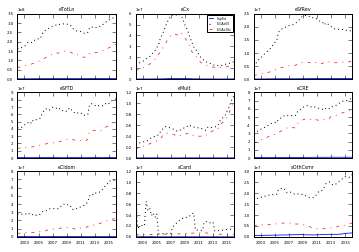

In [83]:
# assumes x18 is second grp, x00 is 1st grp, x31 is third grp:
if len(x3lst) == 3:
  xb = list(bdz3.index)
  plt.rcParams.update({'font.size': 4})

  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
    plt.plot(xb, bdz3[x3lst[2],bcc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
    plt.plot(xb, bdz3[x3lst[1],bcc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
    plt.ylim(ymin=0)
    plt.title(bcc[i],y=.97)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
    if i==1: lg = plt.legend(loc=0, fontsize=3)

    if i < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+'_balhist3.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('skip this section')

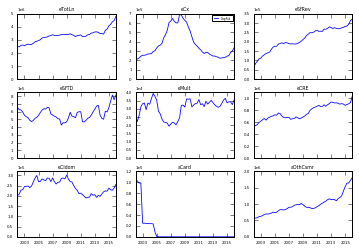

In [84]:
xb = list(bdz3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
  plt.ylim(ymin=0)
  plt.title(bcc[i],y=.97)
  plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
  if i==1: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_balhist1.png', dpi=400, bbox_inches='tight')
plt.show()

In [85]:
bdz3.head(2)

Grp        grpCapCitBan0                                                   \
                   aCard  aOthCsmr    eCIdom      eCRE       eCx    eMult   
AsOf                                                                        
2001-12-31       24210.0  214701.0  139259.0  470848.0  112005.0  25446.0   
2002-03-31       23973.0  211200.0  146231.0  471807.0  115122.0  22277.0   

Grp                                                   ...    grpFLGAx18x  \
             eSfRev     eSfTD     eTotLn   rcCIdom    ...         eTotLn   
AsOf                                                  ...                  
2001-12-31  18591.0  568580.0  1682890.0  0.618558    ...     62379658.0   
2002-03-31  39646.0  545558.0  1678211.0  0.681102    ...     64114964.0   

Grp                                                                     \
             rcCIdom     rcCRE    rcCard      rcCx    rcMult rcOthCsmr   
AsOf                                                                     
2001-12-31  2.558627  0.078968  6.105986  0.090695  0.041319  0.888280   
2002-03-31  2.557351  0.061887  6.411448  0.103871  0.006076  0.947141   

Grp                                       
             rcSfRev    rcSfTD   rcTotLn  
AsOf                                      
2001-12-31  0.055309  0.080574  0.369825  
2002-03-31  0.045046  0.077319  0.368455  

[2 rows x 108 columns]

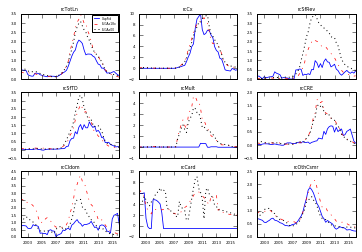

In [86]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohist.png', dpi=400, bbox_inches='tight')
plt.show()

In [87]:
## sections to build stress models for main group: var data in 'hs3' and 'cc3'

In [88]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

rclst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
qclst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

#cbon = vtyp

In [89]:
dfc = df2_3z[df2_3z['Grp']==grp]  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='any', inplace=True)
dfc.head(2)

AsOf        Grp  IDRSSD  nbr     Cert    eTotAst     eTotLn  \
183 2001-12-31  grpCapFid     0.0    5  65966.0  3481816.0  2484148.0   
184 2002-03-31  grpCapFid     0.0    5  65966.0  3418606.0  2470665.0   

       eALLL   eOREO      eGW    ...         eTotrb  eALLL_Ln      mxCx  \
183  28109.0  6237.0  21078.0    ...      12.772060  1.131535  8.455857   
184  29002.0  4888.0   8195.0    ...      13.098508  1.173854  8.702677   

       mxSfFst      mxCRE      mxCI    mxCard      mxDDA    eRWA_TA   lnTotAst  
183  24.563311  21.609461  8.041832  4.469420  20.158286  75.367280  15.063065  
184  23.698114  21.877146  8.429471  4.191098  21.655278  76.270298  15.044743  

[2 rows x 319 columns]

In [90]:
## sUE_CA2 processing
st=''.join(stlst)
hs3.reset_index(drop=False,inplace=True)
hs3.head(2)

Date     rGDPg      nGDPg      rDIg       nDIg        UE       CPI  \
0 2000-03-31  1.048548   4.306565  8.674086  12.608361  4.033333  4.017181   
1 2000-06-30  8.034142  10.241277  4.166088   6.015260  3.933333  3.172469   

        T3m       T5y      T10y       BBB      Mort     Prime        DJ  \
0  5.528730  6.586667  6.670422  8.200528  8.256154  8.686667  14.29618   
1  5.714445  6.416667  6.428826  8.465758  8.310769  9.246667  13.61850   

          HPI      CRE    VIX        CE   CE_FLGA   UE_FLGA  
0  101.617952  127.211  27.01  5.153673  6.263616  3.676631  
1  104.477712  123.935  33.49  5.135676  6.261704  3.721663

In [91]:
## parameters for sUE calcs below (by specified CCAR year):
uex = hs3[['Date','UE']].ix[hs3['UE'].idxmax()]
ccp = cc3[['CCAR','Scen','Date','UE']].iloc[cc3.groupby(['CCAR']).apply(lambda x: x['UE'].idxmax())]

def qtn(d):
  return 4*(d.year - 2000) + d.quarter

uex['qtn'] = qtn(uex['Date'])
ccp['qtn'] = ccp.apply(lambda x: qtn(x['Date']), axis=1)

uep = uex['UE']
ccp['adz'] = uep / ccp['UE']
ccp['que'] = uex['qtn']
ccp['pdt'] = uex['Date']


In [92]:
ccps = []

## parameters for sUE_st calcs below (by specified CCAR year):
if len(stlst)>0:
  UE_st = 'UE_'+''.join(stlst)
  uexs = hs3[['Date',UE_st]].ix[hs3[UE_st].idxmax()]
  ccps = cc3[['CCAR','Scen','Date',UE_st]].iloc[cc3.groupby(['CCAR']).apply(lambda x: x[UE_st].idxmax())]

  uexs['qtn'] = qtn(uexs['Date'])
  ccps['qtn'] = ccps.apply(lambda x: qtn(x['Date']), axis=1)

  ueps = uexs[UE_st]
  ccps['adz'] = ueps / ccps[UE_st]
  ccps['que'] = uexs['qtn']
  ccps['pdt'] = uexs['Date']


In [93]:
ccps

CCAR Scen       Date    UE_FLGA  qtn       adz  que        pdt
20   2012  Sev 2013-03-31  15.284827   53  0.715499   40 2009-12-31
62   2013  Sev 2014-03-31  14.483983   57  0.755060   40 2009-12-31
103  2014  Sev 2014-12-31  12.521296   60  0.873415   40 2009-12-31
144  2015  Sev 2015-09-30  11.318733   63  0.966211   40 2009-12-31
189  2016  Sev 2017-09-30  11.116425   71  0.983795   40 2009-12-31

In [94]:
ccp

CCAR Scen       Date     UE  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  13.05   54  0.758621   40 2009-12-31
63   2013  Sev 2014-06-30  12.10   58  0.818182   40 2009-12-31
105  2014  Sev 2015-06-30  11.30   62  0.876106   40 2009-12-31
147  2015  Sev 2016-06-30  10.10   66  0.980198   40 2009-12-31
189  2016  Sev 2017-09-30  10.00   71  0.990000   40 2009-12-31

In [166]:
##########################################################################################
# Date selection for desired CCAR year:
# note:  CCAR 2013 implies stress period (9q) of 2012Q4 thru 2014Q4 (altho' scenario data goes thru 2015Q4)
##########################################################################################

ccar = 2015

dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)

In [167]:
## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc3[cc3['CCAR'] == ccar]  # ccx contains forecast periods for selected CCAR start year
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)  ## remove var if not included in CCAR list for this year

hsx = hs3.copy()  ## historical macrovars for this run

In [168]:
if vtyp==2:  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccp[ccp['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccp[ccp['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccp[ccp['CCAR']==ccar]['Date'])
  ueinc = (1 - ccp[ccp['CCAR']==ccar]['adz']) / (ccp[ccp['CCAR']==ccar]['qtn'] - ccp[ccp['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE'] = ccx['UE'] * ccx['uead']
  ccx['sUE2'] = ccx['sUE']**2
  if '3' not in styp: ccx['sUE3'] = ccx['sUE']**3
  ccx.drop(['uead','sUE'],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE'] = hsx['UE'] * hsx['uead']
  hsx['sUE2'] = hsx['sUE'] ** 2
  if '3' not in styp: hsx['sUE3'] = hsx['sUE'] ** 3
  hsx.drop(['uead','sUE'],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m     ...      \
40  2015  Sev 2017-09-30    3.9    5.1   2.9   4.2  9.3  1.6  0.1     ...       
41  2015  Sev 2017-12-31    3.9    5.1   3.0   4.3  9.1  1.6  0.1     ...       

    Prime       DJ    HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  \
40    3.2  15.4303  129.5  164.0  16.4  3.873715  3.692378  9.909189   
41    3.2  16.4876  131.0  169.1  16.5  3.841326  3.611930  9.759386   

         sUE2        sUE3  
40  83.357039  761.050402  
41  79.810341  712.998721  

[2 rows x 24 columns]

In [169]:
## sUE_st2 & sUE_st3 vars:
if (vtyp==2)&(len(stlst)>0):  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccps[ccps['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccps[ccps['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccps[ccps['CCAR']==ccar]['Date'])
  ueinc = (1 - ccps[ccps['CCAR']==ccar]['adz']) / (ccps[ccps['CCAR']==ccar]['qtn'] - ccps[ccps['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE_'+''.join(stlst)] = ccx[UE_st] * ccx['uead']
  ccx['sUE_'+''.join(stlst)+'2'] = ccx['sUE_'+''.join(stlst)]**2
  if '3' not in styp: ccx['sUE_'+''.join(stlst)+'3'] = ccx['sUE_'+''.join(stlst)]**3
  ccx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE_'+''.join(stlst)] = hsx['UE_'+''.join(stlst)] * hsx['uead']
  hsx['sUE_'+''.join(stlst)+'2'] = hsx['sUE_'+''.join(stlst)] ** 2
  if '3' not in styp: hsx['sUE_'+''.join(stlst)+'3'] = hsx['sUE_'+''.join(stlst)] ** 3
  hsx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m     ...      \
40  2015  Sev 2017-09-30    3.9    5.1   2.9   4.2  9.3  1.6  0.1     ...       
41  2015  Sev 2017-12-31    3.9    5.1   3.0   4.3  9.1  1.6  0.1     ...       

      HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA       sUE2        sUE3  \
40  129.5  164.0  16.4  3.873715  3.692378  9.909189  83.357039  761.050402   
41  131.0  169.1  16.5  3.841326  3.611930  9.759386  79.810341  712.998721   

    sUE_FLGA2   sUE_FLGA3  
40  91.668484  877.667619  
41  88.917811  838.461536  

[2 rows x 26 columns]

In [170]:
## history vars: lag (4q) vars for UE, HPI, CRE:
if vtyp > 0:
  hsx['UE_4'] = hsx['UE'].shift(4)  ## add 4q lag version of UE
  hsx['HPI_4'] = hsx['HPI'].shift(4)
  hsx['CRE_4'] = hsx['CRE'].shift(4)
  hsx['CE_4'] = hsx['CE'].shift(4)

  ccx[['UE_4','HPI_4','CRE_4','CE_4']] = ccx[['UE','HPI','CRE','CE']].shift(4)
  ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-2)+'-09-30',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-2)+'-12-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-03-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-06-30',['UE','HPI','CRE','CE']].values

  if len(stlst)>0: 
    hsx[UE_st +'_4'] = hsx[UE_st].shift(4)  ## add 4q lag version of UE
    hsx['CE_'+''.join(stlst) +'_4'] = hsx['CE_'+''.join(stlst)].shift(4)  ## add 4q lag version of UE
    ccx[UE_st+'_4'] = ccx[UE_st].shift(4)
    ccx['CE_'+''.join(stlst) +'_4'] = ccx['CE_'+''.join(stlst)].shift(4)
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-12-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-03-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-03-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-06-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-06-30',[UE_st,'CE_'+''.join(stlst)]].values

  ## double check CE, cest, uest vars on boundary date bet hist and forecast (9/30/ccyr-1)
  ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['CE']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['CE']].values

#hsx.dropna(how='any', inplace=True)
hsx.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI   T3m   T5y  T10y  \
59 2014-12-31    2.1    2.2   4.7   4.2  5.7 -0.9  0.02  1.60  2.28   
60 2015-03-31    0.6    0.8   3.9   1.9  5.6 -3.1  0.03  1.45  1.97   
61 2015-06-30    3.9    6.1   2.6   4.9  5.4  3.0  0.02  1.52  2.16   
62 2015-09-30    2.0    3.3   3.8   5.1  5.2  1.6  0.04  1.55  2.22   
63 2015-12-31    1.9    1.9   3.5   3.8  5.0  0.2  0.12  1.59  2.19   

      ...           sUE2        sUE3  sUE_FLGA2   sUE_FLGA3  UE_4  HPI_4  \
59    ...      31.507744  176.858511  34.908379  206.250265   7.0  166.4   
60    ...      30.364884  167.323694        NaN         NaN   6.7  169.3   
61    ...      28.191005  149.680708        NaN         NaN   6.2  170.7   
62    ...      26.100970  133.347532        NaN         NaN   6.1  172.5   
63    ...      24.094415  118.269997        NaN         NaN   5.7  174.5   

    CRE_4      CE_4  UE_FLGA_4  CE_FLGA_4  
59  229.2  4.326582   6.933234   4.487114  
60  230.0  4.374471   6.821136   4.552087  
61  239.0  4.413236   6.609376   4.604520  
62  245.0  4.446018   6.364769   4.655026  
63  252.0  4.470712   6.087184   4.702290  

[5 rows x 30 columns]

In [171]:
ccs = ccx.copy()  # CCAR scenarios for selected year
cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
if 'No' in irflg:
  cccol = [x for x in cccol if x not in xvr] 

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

hsx = hsx[['Date']+cccol]  ## align var columns between hist and ccar lists (& remove forecast rows)
hsz = hsx[hsx['Date']<=frend].merge(dfc[['Grp','IDRSSD','AsOf']+curlst],\
                                    how='left',left_on='Date',right_on='AsOf') # merge hs and df data
### remove any rows with missing data:
hsz.dropna(how='any',inplace=True)
hsy = hsz[hsz['Date']<=dtend]  # cut off table at end of history: (ccar_yr-1)-09-30... use this to build models

ccs['Intercept'] = 1.0  # to set up fitting model

hsz['Intercept'] = 1.0   # to set up fitting for all available history

In [172]:
#######################################################
# 12/13/15: added new code for "big3" variables:
#######################################################
cccol3 = []
if ('Big' in irflg)|('big' in irflg):
  for i in np.arange(len(big3)):
    cccol3 = cccol3 + [x for x in cccol if big3[i] in x]
  cccol = cccol3
  Xcol = ['Intercept'] + cccol

cccol = [x for x in cccol if x[-1]!='3']
Xcol = [x for x in Xcol if x[-1]!='3']
Xcol

['Intercept',
 'rGDPg',
 'nGDPg',
 'rDIg',
 'nDIg',
 'UE',
 'CPI',
 'DJ',
 'HPI',
 'CRE',
 'VIX',
 'CE',
 'CE_FLGA',
 'UE_FLGA',
 'sUE2',
 'sUE_FLGA2',
 'UE_4',
 'HPI_4',
 'CRE_4',
 'CE_4',
 'UE_FLGA_4',
 'CE_FLGA_4']

In [173]:
## model:  du003edb...
## start full model here:

In [174]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsy, return_type='dataframe')
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt.rename(columns = {rc : 'Actual'}, inplace=True)
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.rename(columns = {'pred' : 'Base'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'Adverse'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'SevAdv'}, inplace=True)
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='left', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='left', left_index=True, right_index=True)


In [175]:
frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + styp + irflg + ".csv")
prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + styp + irflg + ".csv")
ccar

2015

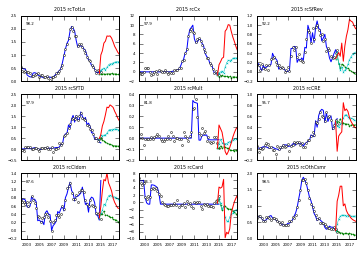

In [176]:
xax = list(frt3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='w',ms=2)
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.5)
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=1)
  plt.title(str(ccar)+" "+curlst[i])
  plt.annotate(str(round(prm3.ix['rsq'][curlst[i]]*100,1)), xy=(0.05, 0.86), xycoords='axes fraction', fontsize=4)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+"_"+str(ccar)+'_full'+str(qtyp) + "q_"+styp+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [177]:
prm3

rcTotLn       rcCx   rcSfRev    rcSfTD    rcMult     rcCRE  \
Intercept -0.220509 -15.830454  6.116159  7.588674 -2.400725  3.880604   
rGDPg     -0.019663  -0.067973 -0.008902 -0.006648 -0.018338  0.009356   
nGDPg      0.026664   0.138484 -0.003520 -0.006897  0.013696 -0.002902   
rDIg      -0.066766  -0.435051  0.027039  0.059118  0.003665 -0.016386   
nDIg       0.064253   0.417877 -0.024425 -0.059587 -0.004980  0.009861   
UE        -1.060038  -8.717107 -1.581727 -1.379974  0.450694 -0.274337   
CPI       -0.060740  -0.390745  0.019161  0.026876  0.001266 -0.019303   
DJ        -0.022233  -0.089280 -0.019977 -0.066526  0.014031 -0.043627   
HPI        0.000853   0.020605 -0.003317  0.001549 -0.002282 -0.003024   
CRE        0.003589   0.013752  0.006255 -0.004101  0.000804  0.003126   
VIX       -0.000454   0.001819 -0.002722 -0.003036 -0.002884 -0.006596   
CE         1.008239   3.059225  1.419787  1.006927  0.416875  0.144648   
CE_FLGA   -0.284265   0.515287 -0.520527 -0.410010 -0.195597  0.014021   
UE_FLGA    0.118286   4.845723  0.451764  0.585042 -0.278636  0.182869   
sUE2       0.065683   0.596494  0.124516  0.102773 -0.042354  0.025045   
sUE_FLGA2  0.011918  -0.248818 -0.032295 -0.038288  0.028625 -0.019101   
UE_4       0.029065  -0.715698  0.462604  0.034055 -0.004904 -0.208990   
HPI_4     -0.014779  -0.047014 -0.022911  0.002281  0.002830  0.001776   
CRE_4      0.005192   0.005965  0.012760  0.007008 -0.004606  0.003110   
CE_4      -0.032984  -0.894577 -3.344218 -2.802114  0.478885 -1.199636   
UE_FLGA_4  0.086122   1.893645 -0.274285  0.068071  0.021134  0.193333   
CE_FLGA_4  0.060085   1.321227  1.662269  0.992799 -0.175327  0.300423   
rsq        0.982096   0.978561  0.921965  0.979401  0.818468  0.957290   

            rcCIdom     rcCard  rcOthCsmr  rcCREtot  
Intercept -6.342069  86.697882  -9.615575 -7.351680  
rGDPg      0.013887  -0.222680   0.010846 -0.022867  
nGDPg      0.001188   0.074920  -0.001760  0.056766  
rDIg      -0.065017  -0.044195  -0.054332 -0.188741  
nDIg       0.062436   0.017366   0.054902  0.182553  
UE         0.970226  -3.666106   1.234977 -2.205992  
CPI       -0.027747  -0.017921  -0.036353 -0.164358  
DJ         0.033302  -0.213985   0.011371 -0.008772  
HPI       -0.009233  -0.049137  -0.003226  0.006669  
CRE       -0.001117  -0.005051   0.001151  0.008696  
VIX        0.004076  -0.011331   0.000232  0.000700  
CE         2.865495  13.804950   0.585316 -0.064125  
CE_FLGA   -0.826809  -8.148744  -0.102907  0.516912  
UE_FLGA   -0.807149  -6.124129  -0.554445  1.050560  
sUE2      -0.039103   0.157620  -0.087992  0.151257  
sUE_FLGA2  0.043033   0.479247   0.055097 -0.046501  
UE_4      -0.194251   5.825748   0.233839 -0.288248  
HPI_4     -0.001970  -0.127299  -0.004907 -0.022627  
CRE_4      0.003128   0.050838   0.003081  0.005442  
CE_4      -0.433618 -15.265111   1.630952  1.419931  
UE_FLGA_4  0.166376  -6.206254  -0.199700  0.640779  
CE_FLGA_4 -0.098185   4.682269  -0.520943 -0.212033  
rsq        0.875867   0.863300   0.984979  0.981055

In [178]:
### build 3-var models:

In [179]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [180]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [181]:
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [182]:
### sections to generate forecasts for all 3-var models:

for idx, row in df3b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] # use this if using top3_rc

  if x == 0:
    frt3b = frt2.copy()
  else:
    frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)

In [183]:
frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt3s.reset_index(drop=False, inplace=True)
frt3s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
#frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn + 1
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv.head(8)

scen        rc    Actual    Adverse       Base       Fit     SevAdv      rc2  \
0     rcTotLn0  0.376574   7.215696   2.641372  0.297616  13.959833  rcTotLn   
1     rcTotLn1  0.376574   6.867497   2.299889  0.293361  13.893658  rcTotLn   
2     rcTotLn2  0.376574   7.270854   2.588538  0.309441  14.356642  rcTotLn   
3        rcCx0 -0.500000  14.023935 -10.093239 -0.240950  50.407258     rcCx   
4        rcCx1 -0.500000  16.883362  -9.514166 -0.158781  58.549052     rcCx   
5        rcCx2 -0.500000  12.193029 -15.059121 -0.876825  48.002704     rcCx   
6     rcSfRev0  0.374954   3.417161   2.132297  0.282011   5.242048  rcSfRev   
7     rcSfRev1  0.374954   3.849415   2.713506  0.346137   5.846073  rcSfRev   

scen  ord       diff  rk  
0       0  13.959833   1  
1       0  13.893658   2  
2       0  14.356642   3  
3       1  50.407258   1  
4       1  58.549052   2  
5       1  48.002704   3  
6       2   5.242048   1  
7       2   5.846073   2

In [184]:
df3bc = df3b.copy()
df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df3bc['rc'] = df3bc.index % topn
df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df3bc.reset_index(drop=True, inplace=True)
df3bc.index.names = [grp+"_"+str(ccar)+"_"+styp]
df3bc.tail()

rc2         v1        r1         v2        r2  \
grpCapFid_2015_Lags_sUE2                                                        
25                        rcOthCsmr  sUE_FLGA2  0.399411  UE_FLGA_4  0.921661   
26                        rcOthCsmr  sUE_FLGA2  0.399411       UE_4  0.893792   
27                         rcCREtot       sUE2  0.899495         UE  0.921149   
28                         rcCREtot  sUE_FLGA2  0.912109      nGDPg  0.924111   
29                         rcCREtot  sUE_FLGA2  0.912109      nGDPg  0.924111   

                                 v3        r3       Int        c1        c2  \
grpCapFid_2015_Lags_sUE2                                                      
25                               UE  0.927777  0.566009  0.013112 -0.207091   
26                             CE_4  0.919016 -0.728551  0.014561 -0.124494   
27                        UE_FLGA_4  0.933172  2.814072  0.117567 -1.224375   
28                              HPI  0.931969 -1.724911  0.031038  0.039854   
29                            HPI_4  0.931897 -1.564141  0.030265  0.052993   

                                c3          rc  ord  rk  
grpCapFid_2015_Lags_sUE2                                 
25                        0.126324  rcOthCsmr1    8   2  
26                        0.308649  rcOthCsmr2    8   3  
27                        0.094860   rcCREtot0    9   1  
28                        0.005208   rcCREtot1    9   2  
29                        0.004212   rcCREtot2    9   3

In [185]:
frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2015

In [186]:
rnk = 1  ## 1 to topn

df_bst = df3bc[df3bc['rk']== rnk][['rc','v1','v2','v3','r3']]
df_bst.dropna(how='any', inplace=True)
df_bst.reset_index(drop=True, inplace=True)

def vlst(x):
  lst = [x['v1'],x['v2'],x['v3'],str(round(x['r3']*100,1))]
  return ';'.join(lst)

df_bst['var'] = df_bst.apply(vlst, axis=1)
dflst = list(df_bst['var'])
#dflst2 = [dflst[i] for i in grord]
dflst

['sUE_FLGA2;CE_FLGA_4;nGDPg;95.8',
 'sUE_FLGA2;UE_4;CE_FLGA_4;93.5',
 'UE_FLGA_4;CE_FLGA_4;CE_FLGA;72.8',
 'UE_FLGA_4;sUE_FLGA2;HPI_4;94.4',
 'UE_4;CE_FLGA_4;HPI;38.2',
 'CE_4;CRE;nDIg;86.0',
 'sUE2;HPI;UE_FLGA;73.3',
 'CRE_4;UE_FLGA_4;CE;64.6',
 'sUE_FLGA2;UE_FLGA_4;DJ;93.0',
 'sUE2;UE;UE_FLGA_4;93.3']

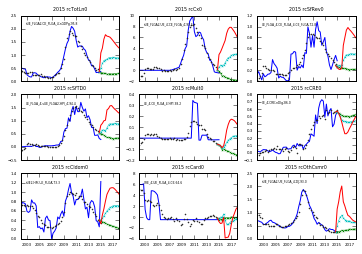

In [187]:
plt.rcParams.update({'font.size': 4})

#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='x',ms=1.5,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=1)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [188]:
grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png'

'grpCapFid_2015_4q_3v9n_Lags_sUE2_3rk1_NoRates.png'

In [189]:
frt3b.ix[:'2012-09-30'][df_bst.ix[i]['rc'],'Actual'][-4:]

Date
2011-12-31    0.623068
2012-03-31    0.569785
2012-06-30    0.528903
2012-09-30    0.480249
Name: (rcOthCsmr0, Actual), dtype: float64

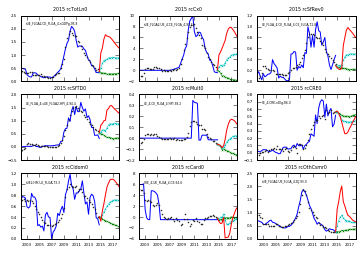

In [190]:
# alt version cuts off act and fit before 1st CCAR forecast period
plt.rcParams.update({'font.size': 4})
xaz=list(frt3b.ix[:str(ccar-1)+'-09-30'].index)
#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='x',ms=1.5,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=1)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'alt.png', dpi=400, bbox_inches='tight')
plt.show()

In [191]:
df3lst = []
for i in np.arange(len(df3bc)):
  ds = df3bc.ix[i]['v1'] + ', ' + df3bc.ix[i]['v2'] + ', ' + df3bc.ix[i]['v3'] +\
         ': '+ str(round(df3bc.ix[i]['r3']*100,1))
  df3lst = df3lst + [ds]

df3bc['Annot'] = df3lst
df3bc[0:2]

rc2         v1        r1         v2        r2  \
grpCapFid_2015_Lags_sUE2                                                      
0                         rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905   
1                         rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905   

                                 v3        r3       Int        c1        c2  \
grpCapFid_2015_Lags_sUE2                                                      
0                             nGDPg  0.957741 -0.649811  0.017667  0.068370   
1                         UE_FLGA_4  0.957518 -1.024974  0.016182  0.112443   

                                c3        rc  ord  rk  \
grpCapFid_2015_Lags_sUE2                                
0                         0.010872  rcTotLn0    0   1   
1                         0.035899  rcTotLn1    0   2   

                                                          Annot  
grpCapFid_2015_Lags_sUE2                                         
0                             sUE_FLGA2, CE_FLGA_4, nGDPg: 95.8  
1                         sUE_FLGA2, CE_FLGA_4, UE_FLGA_4: 95.8

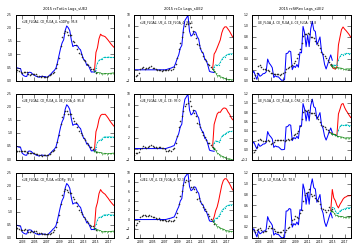

In [192]:
## top3 3-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

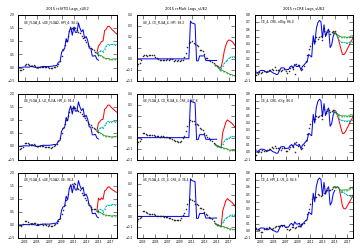

In [193]:
## top3 3-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

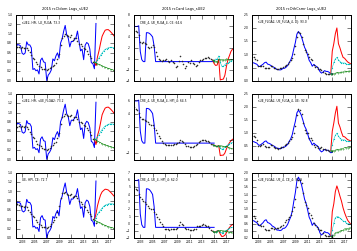

In [194]:
## top3 3-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [195]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v,\
                       data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [196]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
df4b.index = np.arange(len(df4b))

In [197]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

  if x == 0:
    frt4b = frt2.copy()
  else:
    frt4b = frt4b.merge(frt2, how='outer', left_index=True, right_index=True)

In [198]:
frt2.head()

rcTotLn2                              
              Actual       Fit Base Adverse SevAdv
Date                                              
2001-12-31  0.490881  0.376537  NaN     NaN    NaN
2002-03-31  0.491891  0.414918  NaN     NaN    NaN
2002-06-30  0.470024  0.362282  NaN     NaN    NaN
2002-09-30  0.463504  0.407855  NaN     NaN    NaN
2002-12-31  0.247528  0.363024  NaN     NaN    NaN

In [199]:
frt4s = pd.DataFrame(frt4b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt4s.reset_index(drop=False, inplace=True)
frt4s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt4s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
####################################################################
#   NOTE:  this section will determine ordering of models in charts:
#          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
#frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv['diff'] = frpv.apply(lambda x: x['SevAdv']-max(0,x['Base']),axis=1)
#frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
####################################################################
frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
#frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
####################################################################
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.tail(9)

scen          rc    Actual    Adverse      Base       Fit     SevAdv  \
21       rcCard0 -0.500000  -9.423478 -7.608425 -0.235338 -17.220134   
22       rcCard1 -0.500000  -5.458831 -5.520204 -0.683872 -15.704554   
23       rcCard2 -0.500000  -6.971001 -4.765571 -0.470681 -16.621725   
25    rcOthCsmr0  0.269246   6.213386  1.967950  0.135293  10.980570   
24    rcOthCsmr1  0.269246   6.756652  2.719773  0.243208  12.380479   
26    rcOthCsmr2  0.269246   6.060910  3.515971  0.289269  10.470329   
29     rcCREtot0  0.293834   7.293225  2.965278  0.420336  20.197700   
27     rcCREtot1  0.293834   5.457457  0.942643  0.277668  20.612897   
28     rcCREtot2  0.293834  10.274027  3.191880  0.315854  22.232293   

scen        rc2  ord       diff  rk  
21       rcCard    7  -9.611709   0  
22       rcCard    7 -10.184350   1  
23       rcCard    7 -11.856154   2  
25    rcOthCsmr    8   9.012620   1  
24    rcOthCsmr    8   9.660706   0  
26    rcOthCsmr    8   6.954358   2  
29     rcCREtot    9  17.232422   2  
27     rcCREtot    9  19.670254   0  
28     rcCREtot    9  19.040413   1

In [200]:
df4bc = df4b.copy()
df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df4bc['rc'] = df4bc.index % topn
df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df4bc = df4bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df4bc.reset_index(drop=True, inplace=True)
df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9"+styp
df4bc.tail(9)

rc2         v1        r1         v2        r2         v3        r3  \
21     rcCard      CRE_4  0.308023  UE_FLGA_4  0.467823      HPI_4  0.644730   
22     rcCard      CRE_4  0.308023  UE_FLGA_4  0.467823         CE  0.645673   
23     rcCard      CRE_4  0.308023  UE_FLGA_4  0.467823         CE  0.645673   
24  rcOthCsmr  sUE_FLGA2  0.399411  UE_FLGA_4  0.921661         UE  0.927777   
25  rcOthCsmr  sUE_FLGA2  0.399411  UE_FLGA_4  0.921661         DJ  0.929888   
26  rcOthCsmr  sUE_FLGA2  0.399411       UE_4  0.893792       CE_4  0.919016   
27   rcCREtot       sUE2  0.899495         UE  0.921149  UE_FLGA_4  0.933172   
28   rcCREtot       sUE2  0.899495         UE  0.921149  UE_FLGA_4  0.933172   
29   rcCREtot  sUE_FLGA2  0.912109      nGDPg  0.924111        HPI  0.931969   

           v4        r4        Int        c1        c2        c3        c4  \
21       UE_4  0.653677  12.900576  0.004815 -1.451990 -0.075321  1.194414   
22        CRE  0.651045  41.213218 -0.041141 -1.300201 -4.625768 -0.011002   
23      HPI_4  0.650254  31.212121 -0.029012 -1.029167 -2.837473 -0.031324   
24       CE_4  0.944188  -1.854429  0.007241 -0.133984  0.216924  0.330383   
25      CRE_4  0.941274   0.894764  0.014181 -0.129193 -0.036710  0.002337   
26  CE_FLGA_4  0.939252  -5.293058  0.010814 -0.020902  1.937954 -0.676060   
27    UE_FLGA  0.946472   3.537086  0.118109 -1.634163  0.112686  0.278510   
28        VIX  0.945765   3.487752  0.132501 -1.538458  0.155539  0.011632   
29        VIX  0.940134  -2.613559  0.031074  0.075057  0.007711  0.012696   

            rc  ord  rk                         Desc  
21     rcCard0    7   0  grpCapFid_2015_4v9Lags_sUE2  
22     rcCard1    7   1  grpCapFid_2015_4v9Lags_sUE2  
23     rcCard2    7   2  grpCapFid_2015_4v9Lags_sUE2  
24  rcOthCsmr0    8   1  grpCapFid_2015_4v9Lags_sUE2  
25  rcOthCsmr1    8   0  grpCapFid_2015_4v9Lags_sUE2  
26  rcOthCsmr2    8   2  grpCapFid_2015_4v9Lags_sUE2  
27   rcCREtot0    9   2  grpCapFid_2015_4v9Lags_sUE2  
28   rcCREtot1    9   0  grpCapFid_2015_4v9Lags_sUE2  
29   rcCREtot2    9   1  grpCapFid_2015_4v9Lags_sUE2

In [201]:
frt4b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2015

In [202]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bc)):
  ds1 = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ','
  ds2 = df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bc['Annot1'] = df4lst1
df4bc['Annot2'] = df4lst2
df4bc[0:2]

rc2         v1        r1         v2        r2     v3        r3   v4  \
0  rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  VIX   
1  rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  CPI   

         r4       Int        c1        c2        c3        c4        rc  ord  \
0  0.960816 -0.725556  0.017173  0.057841  0.022060  0.004247  rcTotLn0    0   
1  0.959922 -0.691868  0.017793  0.076114  0.016855 -0.014818  rcTotLn1    0   

   rk                         Desc                        Annot1     Annot2  
0   1  grpCapFid_2015_4v9Lags_sUE2  sUE_FLGA2, CE_FLGA_4, nGDPg,  VIX: 96.1  
1   2  grpCapFid_2015_4v9Lags_sUE2  sUE_FLGA2, CE_FLGA_4, nGDPg,  CPI: 96.0

In [203]:
##################################################################################
# select highest R-squared model:
#md = [0,0,0,0,0,0,0,0,0]  # note: use this to rank based on R-squared
#mdr = [x for x in list(df4bc['rc']) if x[-1]=='0']

# special code to select "best" model based on max 9q diff between SevAdv and Base forecasts:
md=list(df4bc[df4bc['rk']==0]['rc'])  # note: use this if you want models based on diff calc (SevAdv - Bas ranking)
mdr = [x[-1] for x in md]

mdr, md

(['2', '1', '2', '0', '1', '0', '2', '0', '1', '1'],
 ['rcTotLn2',
  'rcCx1',
  'rcSfRev2',
  'rcSfTD0',
  'rcMult1',
  'rcCRE0',
  'rcCIdom2',
  'rcCard0',
  'rcOthCsmr1',
  'rcCREtot1'])

In [204]:
curlst

['rcTotLn',
 'rcCx',
 'rcSfRev',
 'rcSfTD',
 'rcMult',
 'rcCRE',
 'rcCIdom',
 'rcCard',
 'rcOthCsmr',
 'rcCREtot']

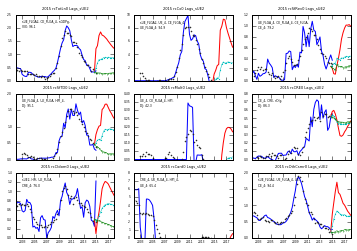

In [205]:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

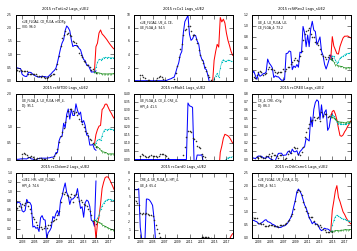

In [206]:
## special version for TotUSx18 only... best version based on diff bet SevAdv and Base:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

#ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

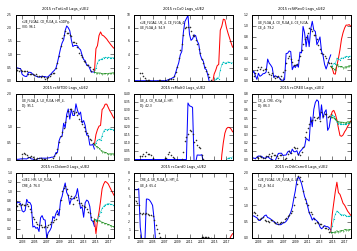

In [207]:
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

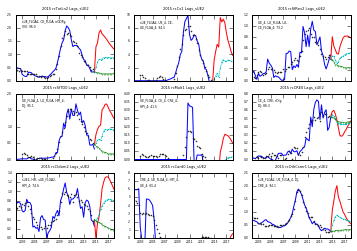

In [208]:
## special version for 2013 TotUSx18 only... best diff sevadv - base (9q only)
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.ylim(ymin=0)

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

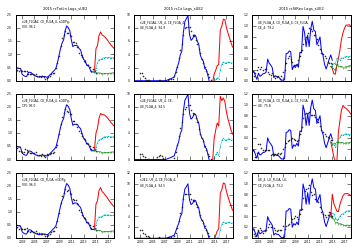

In [209]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

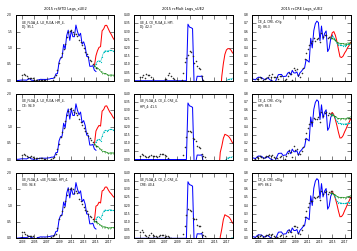

In [210]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

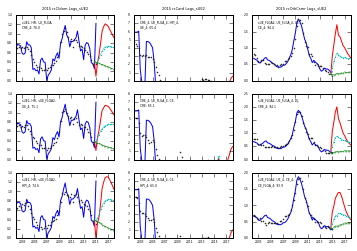

In [211]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [212]:
## repeat triple charts cutting off actual and fitted to prior Sept (9/30/2012 for 2013 CCAR)

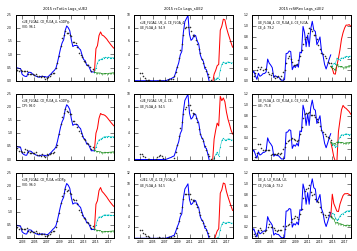

In [213]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

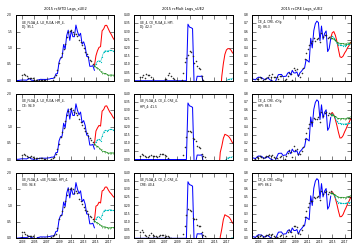

In [214]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

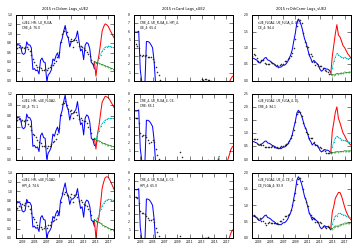

In [215]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=1,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [216]:
## section to calculate volumes of NCOs from the forecasted NCO rates:

In [217]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
svm = "SevAdv"  ######### changed on 12/8/15 from sm to svm to avoid statsmodels abbreviation

In [218]:
grporig

'grpCapFid'

In [219]:
## volumes file:
vofi = "df2_3z_"+grporig+".csv"            ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0)
vo = vo[vo['Grp']==grp]
vo.rename(columns={"AsOf":"Date"}, inplace=True)
vo['Date'] = pd.to_datetime(vo['Date'])
vo.set_index('Date',drop=True,inplace=True)

dfz1 = []
dfz3 = []

In [220]:
#vv = 2  ## 0,1,2 only:  selects vlst item

#mn = 1 # single models per rc ("full" files)
#mn = 3 # 3 vars per rc ("3v" files)
mn = 4 # 4 vars per rc ("4v" files)

#rkfi = pd.read_csv(grp+'_allyr_' + str(rtyp) +'_'+str(mn)+'v10best_'+cbo[vv]+'.csv', index_col=0)
#rkfi.set_index('ccar',drop=True, inplace=True)

In [221]:
dttr = str(ccar-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
dtst = str(ccar-1) + "-12-31"  # start of 9q forecast period
dten = str(ccar+1) + "-12-31"  # end of 9q forecast period
  
if mn == 1:
  mtyp = '_full_'
elif mn == 3:
  mtyp = '_3v_'
elif mn == 4:
  mtyp = '_4v_'
else:
  mtyp = 'xxx'  # force error to fix problem
  
hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
  
rtfi = grp + "_" + str(ccar) + mtyp + "9fcst_" + rtyp +"_" + styp +irflg + ".csv" ## file with modeled ccar forecast nco/fail rates
rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
  
paramfi = grp + "_" + str(ccar) + mtyp + "9param_" + rtyp +"_"  + styp +irflg + ".csv"  ## param file for same run
param = pd.read_csv(paramfi, index_col=0, header=0)
param.index.name= 'scen'
  
### start prod loops here:
balst= []
dmlst = []


In [222]:
param.head(2)

rc2         v1        r1         v2        r2     v3        r3   v4  \
scen                                                                            
0     rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  VIX   
1     rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  CPI   

            r4       Int        c1        c2        c3        c4        rc  \
scen                                                                         
0     0.960816 -0.725556  0.017173  0.057841  0.022060  0.004247  rcTotLn0   
1     0.959922 -0.691868  0.017793  0.076114  0.016855 -0.014818  rcTotLn1   

      ord  rk                         Desc  
scen                                        
0       0   1  grpCapFid_2015_4v9Lags_sUE2  
1       0   2  grpCapFid_2015_4v9Lags_sUE2

In [223]:
#for pr in np.arange(2):
for pr in np.arange(len(rt.columns.levels[0])):
  if mn > 1:
    prn = rclst[int(pr/topn)]+str(pr % topn)  # add rank suffix to prodname
  else:
    prn = rclst[int(pr/topn)]    ## just use prodname
  prnm = rclst[int(pr/topn)]     ## prod name (no rank suffix)
  drt = rt[prn]
  df = vo[[nmz[prnm],dmz[prnm]]]
  df.columns = ['nco','bal']
  
  dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
  
  # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
  dfr['Fv'] = dfr['nco']  # added 12/12
  dfr['Bv'] = dfr['nco']
  dfr['Av'] = dfr['nco']
  dfr['Sv'] = dfr['nco']
  
  dfr['bal'] = dfr['bal'].fillna(method='pad')
  dfr[[bm,am,svm]] = dfr[[bm,am,svm]].fillna(-999)
  
  dfr.ix[dttr][bm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][bm] == -999:
      dfr.ix[x][bv] = dfr.ix[x].nco
      dfr.ix[x][fv] = dfr.ix[x].nco # added 12/12
    else:
      if rtyp == "4q":
        dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
        dfr.ix[x][fv] = dfr.ix[x][fm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][fv] +dfr.ix[x-2][fv] +dfr.ix[x-3][fv])  # added 12/12
      else:
        dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
        dfr.ix[x][fv] = dfr.ix[x][fm] * dfr.ix[x].bal/400  # added 12/12
  
  dfr.ix[dttr][am] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][am] == -999:
      dfr.ix[x][av] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
      else:
        dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
  
  dfr.ix[dttr][svm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][svm] == -999:
      dfr.ix[x][sv] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][sv] = dfr.ix[x][svm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
      else:
        dfr.ix[x][sv] = dfr.ix[x][svm] * dfr.ix[x].bal/400 
  
  ## NEW SECTION:
  dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
  for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
    if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
      if np.isnan(dfr.ix[i]['Adverse']):
        dfr.ix[i]['Av'] = np.nan
  
  dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv) 
  
  r9q = pd.rolling_sum(dfr['2006-12-31':dtst]['nco'],window=9, min_periods=9)
  r9q = r9q.dropna()
  r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
  
  dfv2 = pd.DataFrame(dfv, columns=[prn])
  dfv2.ix['ActMx'] = r9qm.values[0]
  dfv2.ix['DateMx'] = r9qm.index[0]
  dfv2t = dfv2.T
  dfv2t.reset_index(drop=False, inplace=True)
  
  b9q = pd.rolling_mean(dfr['2006-12-31':dtst]['bal'],window=9, min_periods=9)
  balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
  
  dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
#  voldet = dfr.ix[str(ccar-1)+'-01-01':]
  voldet = dfr.ix[str(ccar-3)+'-01-01':]
  voldet.columns = pd.MultiIndex.from_product([[prn], list(voldet.columns)])
  
  if pr == 0:
    dfvr = dfv2t
    voldet2 = voldet.copy()
  else:
    dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
#    voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    voldet2 = pd.concat([voldet,voldet2],ignore_index=True,axis=1)

In [224]:
dfvr

index       Bv       Av       Sv   ActMx               DateMx
0     rcTotLn0  27632.8  89623.2   186165  129621  2010-12-31 00:00:00
1     rcTotLn1  27996.6  86980.4   178817  129621  2010-12-31 00:00:00
2     rcTotLn2  26658.5  90135.5   190165  129621  2010-12-31 00:00:00
3        rcCx0 -7353.82  14474.4  53421.3   70837  2010-12-31 00:00:00
4        rcCx1 -7574.06  17409.4  61167.7   70837  2010-12-31 00:00:00
5        rcCx2 -9459.26  13660.5  53092.1   70837  2010-12-31 00:00:00
6     rcSfRev0  1209.07  2271.74  3891.96    5286  2012-03-31 00:00:00
7     rcSfRev1  1643.93   2195.9  4060.39    5286  2012-03-31 00:00:00
8     rcSfRev2  1552.92  2779.95  5250.99    5286  2012-03-31 00:00:00
9      rcSfTD0  4283.47  14913.8  28006.7   17926  2011-09-30 00:00:00
10     rcSfTD1  4708.78    14705  27867.8   17926  2011-09-30 00:00:00
11     rcSfTD2  6843.28  14732.3  27780.4   17926  2011-09-30 00:00:00
12     rcMult0 -73.2144  -41.519  7.46198     118  2012-03-31 00:00:00
13     rcMult1 -86.7213 -36.9489  48.4312     118  2012-03-31 00:00:00
14     rcMult2 -101.968  -63.326  25.5103     118  2012-03-31 00:00:00
15      rcCRE0  9372.71  9199.79   8125.7   13740  2013-06-30 00:00:00
16      rcCRE1  10480.3  9430.32  7522.48   13740  2013-06-30 00:00:00
17      rcCRE2  10522.9  9254.43  7474.78   13740  2013-06-30 00:00:00
18    rcCIdom0  2145.73     3914  5352.39    5629  2011-03-31 00:00:00
19    rcCIdom1  1885.47  4023.51  5474.87    5629  2011-03-31 00:00:00
20    rcCIdom2   1764.7  4295.37  5491.72    5629  2011-03-31 00:00:00
21     rcCard0        8        8        8     -26  2014-12-31 00:00:00
22     rcCard1        8        8        8     -26  2014-12-31 00:00:00
23     rcCard2        8        8        8     -26  2014-12-31 00:00:00
24  rcOthCsmr0  8541.86  29236.7  49448.8   32655  2010-03-31 00:00:00
25  rcOthCsmr1  12531.5  31794.8  55064.6   32655  2010-03-31 00:00:00
26  rcOthCsmr2  16618.5  29034.2  49450.6   32655  2010-03-31 00:00:00
27   rcCREtot0  9585.84  27712.7    81527   75234  2011-06-30 00:00:00
28   rcCREtot1  845.099  20188.8  82690.6   75234  2011-06-30 00:00:00
29   rcCREtot2  10423.5  37536.4  85559.5   75234  2011-06-30 00:00:00

In [225]:
voldet.head(2)

rcCREtot2                                                     \
                 nco        bal    Actual       Fit Base Adverse SevAdv   
Date                                                                      
2012-03-31    2920.0  1184361.0  1.960239  1.505739  NaN     NaN    NaN   
2012-06-30    6427.0  1197125.0  1.845389  1.401381  NaN     NaN    NaN   

                                            
                Fv      Bv      Av      Sv  
Date                                        
2012-03-31  2920.0  2920.0  2920.0  2920.0  
2012-06-30  6427.0  6427.0  6427.0  6427.0

In [226]:
if mn > 1:
  dfvr2 = dfvr.copy()
  dfvr2['bal'] = dmlst
  dfvr2['ActBalMx'] = balst
  dfvr2['rk']  = dfvr2.index % mn
  dfvr2['rk'] += 1
  
  dfvr2t = dfvr2.copy()
  dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/(dfvr2t['ActBalMx']+.000001)
  dfvr2t['ModRt'] = dfvr2t['Sv']*100/(dfvr2t['bal']+.000001)
  dfvr2t = dfvr2t[['index','bal','Bv','Av','Sv','ActMx','ActBalMx','DateMx','ActMxRt','ModRt']] # chgd 12/12 'Fv'
  dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
  dfvr2t['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp + styp
  dfvr2t.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_vol.csv")
  voldet2.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_voldet.csv")
  dfz3 = dfvr2t.copy()
  
if mn == 1:
  dfvr['bal'] = dmlst
  dfvr['ActBalMx'] = balst
  dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
  
  dfvrt = dfvr.copy()
  dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
  dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
  dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
  dfvrt['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp +"_"+ styp
  dfvrt.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv")
  voldet.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_voldet.csv")
  dfz1 = dfvrt.copy()

In [227]:
voldet.head()

rcCREtot2                                                     \
                 nco        bal    Actual       Fit Base Adverse SevAdv   
Date                                                                      
2012-03-31    2920.0  1184361.0  1.960239  1.505739  NaN     NaN    NaN   
2012-06-30    6427.0  1197125.0  1.845389  1.401381  NaN     NaN    NaN   
2012-09-30     983.0  1202708.0  1.434493  1.244106  NaN     NaN    NaN   
2012-12-31    2720.0  1220067.0  1.086535  0.933371  NaN     NaN    NaN   
2013-03-31    3609.0  1211358.0  1.137509  0.990842  NaN     NaN    NaN   

                                            
                Fv      Bv      Av      Sv  
Date                                        
2012-03-31  2920.0  2920.0  2920.0  2920.0  
2012-06-30  6427.0  6427.0  6427.0  6427.0  
2012-09-30   983.0   983.0   983.0   983.0  
2012-12-31  2720.0  2720.0  2720.0  2720.0  
2013-03-31  3609.0  3609.0  3609.0  3609.0

In [228]:
grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv"

'grpCapFid_2015_4v_4q_Lags_sUE2_NoRates_vol.csv'

In [5]:
grp = grporig  # reset to original grp designation
grp, styp, irflg

('grpCapFid', 'Lags_sUE2', '_NoRates')

In [ ]:
## special charts for CapFid:

In [8]:
cf = pd.read_csv("df2_3z_grpCapFid.csv",index_col=0)
cf['AsOf'] = pd.to_datetime(cf['AsOf'])
cf.tail(2)

AsOf            Grp     IDRSSD  nbr    Cert    eTotAst     eTotLn  \
538 2015-09-30  grpCapCitBan0  1120754.0    2  9622.0  2596094.0  1486144.0   
539 2015-12-31  grpCapCitBan0  1120754.0    2  9622.0  2778676.0  1503907.0   

       eALLL    eOREO      eGW    ...      eTotrb  eALLL_Ln      mxCx  \
538  14737.0  25219.0  84810.0    ...         0.0  0.991627  7.221373   
539  13953.0  19290.0  84810.0    ...         0.0  0.927783  7.686513   

       mxSfFst      mxCRE      mxCI  mxCard      mxDDA  eRWA_TA   lnTotAst  
538  18.560247  25.616629  8.350671     0.0  34.792521      0.0  14.769519  
539  18.216219  24.842228  8.602460     0.0  33.519106      0.0  14.837485  

[2 rows x 319 columns]

In [9]:
curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] 

In [10]:
cf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp                
grpCapCitBan0    60
grpCapFid        60
grpFIDBAN0       60
grpFLGAx00       60
grpFLGAx18       60
grpFLGAx18x      60
grpTotUSx00      60
grpTotUSx18      60
grpTotUSx31      60

In [11]:
x3lst = ['grpCapFid','grpCapCitBan0','grpFIDBAN0']
x3lst

['grpCapFid', 'grpCapCitBan0', 'grpFIDBAN0']

In [12]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [13]:
bdf = cf[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn       eCx    eSfRev     eSfTD    eMult  \
Grp           AsOf                                                           
grpCapCitBan0 2014-12-31  1442062.0  108494.0  203660.0  287374.0  26483.0   
              2015-03-31  1464788.0  105377.0  203759.0  288091.0  27129.0   
              2015-06-30  1485256.0  106774.0  207660.0  289399.0  26254.0   
              2015-09-30  1486144.0  107320.0  210883.0  284037.0  24438.0   
              2015-12-31  1503907.0  115598.0  214618.0  283211.0  27387.0   

                              eCRE    eCIdom  aCard  aOthCsmr  
Grp           AsOf                                             
grpCapCitBan0 2014-12-31  387650.0  123037.0    0.0  208292.0  
              2015-03-31  393539.0  122198.0    0.0  224534.0  
              2015-06-30  389404.0  120350.0    0.0  237346.0  
              2015-09-30  380700.0  124103.0    0.0  240027.0  
              2015-12-31  373604.0  129373.0    0.0  240262.0

In [14]:
ndf = cf[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp         AsOf                                                           
grpTotUSx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
            2001-06-30       NaN       NaN       NaN       NaN       NaN   
            2001-09-30       NaN       NaN       NaN       NaN       NaN   
            2001-12-31  0.906950  0.128401  0.254723  0.198517  0.028189   
            2002-03-31  1.003935  0.140850  0.238045  0.206689  0.029043   

                           rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp         AsOf                                                 
grpTotUSx00 2001-03-31       NaN       NaN       NaN        NaN  
            2001-06-30       NaN       NaN       NaN        NaN  
            2001-09-30       NaN       NaN       NaN        NaN  
            2001-12-31  0.123373  1.712288  5.685286   1.381422  
            2002-03-31  0.139262  1.870484  6.531011   1.473849

In [15]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn          eCx       eSfRev        eSfTD  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0   
            2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0   

                             eMult         eCRE       eCIdom        aCard  \
Grp         AsOf                                                            
grpTotUSx00 2001-03-31  74421523.0  493334312.0  832079914.0  205311052.0   
            2001-06-30  74003767.0  502028474.0  812822577.0  205481263.0   

                           aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  359867608.0      NaN   NaN      NaN     NaN     NaN   
            2001-06-30  366821155.0      NaN   NaN      NaN     NaN     NaN   

                        rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp         AsOf                                           
grpTotUSx00 2001-03-31    NaN      NaN     NaN        NaN  
            2001-06-30    NaN      NaN     NaN        NaN

In [16]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp        grpCapCitBan0                                                   \
                   aCard  aOthCsmr    eCIdom      eCRE       eCx    eMult   
AsOf                                                                        
2001-12-31       24210.0  214701.0  139259.0  470848.0  112005.0  25446.0   
2002-03-31       23973.0  211200.0  146231.0  471807.0  115122.0  22277.0   

Grp                                                   ...      grpTotUSx31  \
             eSfRev     eSfTD     eTotLn   rcCIdom    ...           eTotLn   
AsOf                                                  ...                    
2001-12-31  18591.0  568580.0  1682890.0  0.618558    ...     1.200898e+09   
2002-03-31  39646.0  545558.0  1678211.0  0.681102    ...     1.201609e+09   

Grp                                                                     \
             rcCIdom     rcCRE    rcCard      rcCx    rcMult rcOthCsmr   
AsOf                                                                     
2001-12-31  1.753906  0.092592  8.035095  0.124872  0.022294  0.969311   
2002-03-31  1.868647  0.101647  8.051116  0.138525  0.028256  0.998264   

Grp                                       
             rcSfRev    rcSfTD   rcTotLn  
AsOf                                      
2001-12-31  0.122498  0.071273  0.592149  
2002-03-31  0.108662  0.075425  0.599545  

[2 rows x 162 columns]

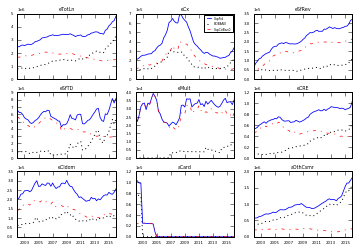

In [17]:
# assumes x18 is second grp, x00 is 1st grp, x31 is third grp:
if len(x3lst) == 3:
  xb = list(bdz3.index)
  plt.rcParams.update({'font.size': 4})

  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
    plt.plot(xb, bdz3[x3lst[2],bcc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
    plt.plot(xb, bdz3[x3lst[1],bcc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
    plt.ylim(ymin=0)
    plt.title(bcc[i],y=.97)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
    if i==1: lg = plt.legend(loc=0, fontsize=3)

    if i < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+'_balhist3spec.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('skip this section')

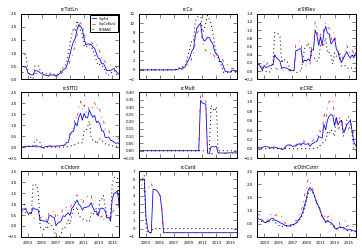

In [19]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohistspec.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
grp

'grpCapFid'

In [20]:
x3lst = ['grpCapFid','grpFLGAx18x','grpTotUSx00']
x3lst

['grpCapFid', 'grpFLGAx18x', 'grpTotUSx00']

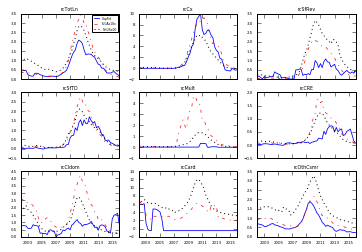

In [21]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohistspec2.png', dpi=400, bbox_inches='tight')
plt.show()

In [6]:
## capfid vs TotUS nco special charts

In [7]:
cf = pd.read_csv("df2_3z_grpCapFid.csv",index_col=0)
cf['AsOf'] = pd.to_datetime(cf['AsOf'])
cf.tail(2)

AsOf            Grp     IDRSSD  nbr    Cert    eTotAst     eTotLn  \
538 2015-09-30  grpCapCitBan0  1120754.0    2  9622.0  2596094.0  1486144.0   
539 2015-12-31  grpCapCitBan0  1120754.0    2  9622.0  2778676.0  1503907.0   

       eALLL    eOREO      eGW    ...      eTotrb  eALLL_Ln      mxCx  \
538  14737.0  25219.0  84810.0    ...         0.0  0.991627  7.221373   
539  13953.0  19290.0  84810.0    ...         0.0  0.927783  7.686513   

       mxSfFst      mxCRE      mxCI  mxCard      mxDDA  eRWA_TA   lnTotAst  
538  18.560247  25.616629  8.350671     0.0  34.792521      0.0  14.769519  
539  18.216219  24.842228  8.602460     0.0  33.519106      0.0  14.837485  

[2 rows x 319 columns]

In [8]:
curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] 

In [9]:
cf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp                
grpCapCitBan0    60
grpCapFid        60
grpFIDBAN0       60
grpFLGAx00       60
grpFLGAx18       60
grpFLGAx18x      60
grpTotUSx00      60
grpTotUSx18      60
grpTotUSx31      60

In [10]:
x3lst = ['grpCapFid','grpFLGAx18x','grpTotUSx00']
x3lst

['grpCapFid', 'grpFLGAx18x', 'grpTotUSx00']

In [11]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [12]:
bdf = cf[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn       eCx    eSfRev     eSfTD    eMult  \
Grp           AsOf                                                           
grpCapCitBan0 2014-12-31  1442062.0  108494.0  203660.0  287374.0  26483.0   
              2015-03-31  1464788.0  105377.0  203759.0  288091.0  27129.0   
              2015-06-30  1485256.0  106774.0  207660.0  289399.0  26254.0   
              2015-09-30  1486144.0  107320.0  210883.0  284037.0  24438.0   
              2015-12-31  1503907.0  115598.0  214618.0  283211.0  27387.0   

                              eCRE    eCIdom  aCard  aOthCsmr  
Grp           AsOf                                             
grpCapCitBan0 2014-12-31  387650.0  123037.0    0.0  208292.0  
              2015-03-31  393539.0  122198.0    0.0  224534.0  
              2015-06-30  389404.0  120350.0    0.0  237346.0  
              2015-09-30  380700.0  124103.0    0.0  240027.0  
              2015-12-31  373604.0  129373.0    0.0  240262.0

In [13]:
ndf = cf[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp         AsOf                                                           
grpTotUSx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
            2001-06-30       NaN       NaN       NaN       NaN       NaN   
            2001-09-30       NaN       NaN       NaN       NaN       NaN   
            2001-12-31  0.906950  0.128401  0.254723  0.198517  0.028189   
            2002-03-31  1.003935  0.140850  0.238045  0.206689  0.029043   

                           rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp         AsOf                                                 
grpTotUSx00 2001-03-31       NaN       NaN       NaN        NaN  
            2001-06-30       NaN       NaN       NaN        NaN  
            2001-09-30       NaN       NaN       NaN        NaN  
            2001-12-31  0.123373  1.712288  5.685286   1.381422  
            2002-03-31  0.139262  1.870484  6.531011   1.473849

In [14]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn          eCx       eSfRev        eSfTD  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0   
            2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0   

                             eMult         eCRE       eCIdom        aCard  \
Grp         AsOf                                                            
grpTotUSx00 2001-03-31  74421523.0  493334312.0  832079914.0  205311052.0   
            2001-06-30  74003767.0  502028474.0  812822577.0  205481263.0   

                           aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  359867608.0      NaN   NaN      NaN     NaN     NaN   
            2001-06-30  366821155.0      NaN   NaN      NaN     NaN     NaN   

                        rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp         AsOf                                           
grpTotUSx00 2001-03-31    NaN      NaN     NaN        NaN  
            2001-06-30    NaN      NaN     NaN        NaN

In [15]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp        grpCapCitBan0                                                   \
                   aCard  aOthCsmr    eCIdom      eCRE       eCx    eMult   
AsOf                                                                        
2001-12-31       24210.0  214701.0  139259.0  470848.0  112005.0  25446.0   
2002-03-31       23973.0  211200.0  146231.0  471807.0  115122.0  22277.0   

Grp                                                   ...      grpTotUSx31  \
             eSfRev     eSfTD     eTotLn   rcCIdom    ...           eTotLn   
AsOf                                                  ...                    
2001-12-31  18591.0  568580.0  1682890.0  0.618558    ...     1.200898e+09   
2002-03-31  39646.0  545558.0  1678211.0  0.681102    ...     1.201609e+09   

Grp                                                                     \
             rcCIdom     rcCRE    rcCard      rcCx    rcMult rcOthCsmr   
AsOf                                                                     
2001-12-31  1.753906  0.092592  8.035095  0.124872  0.022294  0.969311   
2002-03-31  1.868647  0.101647  8.051116  0.138525  0.028256  0.998264   

Grp                                       
             rcSfRev    rcSfTD   rcTotLn  
AsOf                                      
2001-12-31  0.122498  0.071273  0.592149  
2002-03-31  0.108662  0.075425  0.599545  

[2 rows x 162 columns]

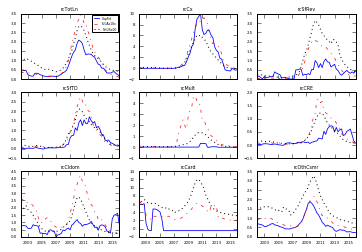

In [17]:
plt.rcParams.update({'font.size': 4})
xb = list(bdz3.index)

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohistspec2.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
## special forecast charts: CapFid vs TotUS for Mult, CRE

In [21]:
frt4b = pd.read_csv('grpCapFid_2015_4v_9fcst_4q_Lags_sUE2_norates.csv',header=[0,1],index_col=0,parse_dates=True)
frt4b.head(2)

rcCIdom0                                rcCIdom1                 \
              Actual       Fit Base Adverse SevAdv    Actual       Fit Base   
Date                                                                          
2001-12-31  0.707966  0.705710  NaN     NaN    NaN  0.707966  0.710558  NaN   
2002-03-31  0.773029  0.695949  NaN     NaN    NaN  0.773029  0.720513  NaN   

                           ...    rcTotLn1                                \
           Adverse SevAdv  ...      Actual       Fit Base Adverse SevAdv   
Date                       ...                                             
2001-12-31     NaN    NaN  ...    0.490881  0.367045  NaN     NaN    NaN   
2002-03-31     NaN    NaN  ...    0.491891  0.423179  NaN     NaN    NaN   

            rcTotLn2                                
              Actual       Fit Base Adverse SevAdv  
Date                                                
2001-12-31  0.490881  0.376537  NaN     NaN    NaN  
2002-03-31  0.491891  0.414918  NaN     NaN    NaN  

[2 rows x 150 columns]

In [23]:
df4bc=pd.read_csv('grpCapFid_2015_4v_9param_4q_Lags_sUE2_norates.csv',index_col=0)
df4bc.head(2)

rc2         v1        r1         v2        r2     v3        r3   v4  \
0  rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  VIX   
1  rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  CPI   

         r4       Int        c1        c2        c3        c4        rc  ord  \
0  0.960816 -0.725556  0.017173  0.057841  0.022060  0.004247  rcTotLn0    0   
1  0.959922 -0.691868  0.017793  0.076114  0.016855 -0.014818  rcTotLn1    0   

   rk                         Desc  
0   1  grpCapFid_2015_4v9Lags_sUE2  
1   2  grpCapFid_2015_4v9Lags_sUE2

In [24]:
frt4u = pd.read_csv('grpTotUSx00_2015_4v_9fcst_4q_Lags_sUE2_norates.csv',header=[0,1],index_col=0,parse_dates=True)
frt4u.head(2)

rcCIdom0                                rcCIdom1                 \
              Actual       Fit Base Adverse SevAdv    Actual       Fit Base   
Date                                                                          
2001-12-31  1.712288  1.648560  NaN     NaN    NaN  1.712288  1.747956  NaN   
2002-03-31  1.870484  1.656667  NaN     NaN    NaN  1.870484  1.760050  NaN   

                           ...    rcTotLn1                                \
           Adverse SevAdv  ...      Actual       Fit Base Adverse SevAdv   
Date                       ...                                             
2001-12-31     NaN    NaN  ...    0.906950  1.091295  NaN     NaN    NaN   
2002-03-31     NaN    NaN  ...    1.003935  1.070970  NaN     NaN    NaN   

            rcTotLn2                                
              Actual       Fit Base Adverse SevAdv  
Date                                                
2001-12-31  0.906950  0.876375  NaN     NaN    NaN  
2002-03-31  1.003935  0.828578  NaN     NaN    NaN  

[2 rows x 150 columns]

In [27]:
df4bu=pd.read_csv('grpTotUSx00_2015_4v_9param_4q_Lags_sUE2_norates.csv',index_col=0)
df4bu.head(2)

rc2    v1        r1  v2        r2   v3        r3   v4        r4  \
0  rcTotLn  sUE2  0.862524  DJ  0.911974   UE  0.931470  HPI  0.948797   
1  rcTotLn  sUE2  0.862524  CE  0.908377  HPI  0.926692   UE  0.947869   

        Int        c1        c2        c3        c4        rc  ord  rk  \
0  5.189106  0.099063 -0.010448 -1.095618 -0.008229  rcTotLn0    0   1   
1  5.170489  0.102657  0.044097 -0.009419 -1.142625  rcTotLn1    0   2   

                            Desc  
0  grpTotUSx00_2015_4v9Lags_sUE2  
1  grpTotUSx00_2015_4v9Lags_sUE2

In [28]:
frt4b['rcCRE0'].head(2)

Actual       Fit  Base  Adverse  SevAdv
Date                                                 
2001-12-31  0.015023  0.018759   NaN      NaN     NaN
2002-03-31  0.019174 -0.053975   NaN      NaN     NaN

In [29]:
curlst

['rcTotLn',
 'rcCx',
 'rcSfRev',
 'rcSfTD',
 'rcMult',
 'rcCRE',
 'rcCIdom',
 'rcCard',
 'rcOthCsmr',
 'rcCREtot']

In [32]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bc)):
  ds1 = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', '
  ds2 = df4bc.ix[i]['v3'] + ',' + df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bc['Annot1'] = df4lst1
df4bc['Annot2'] = df4lst2
df4bc[0:2]

rc2         v1        r1         v2        r2     v3        r3   v4  \
0  rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  VIX   
1  rcTotLn  sUE_FLGA2  0.948251  CE_FLGA_4  0.955905  nGDPg  0.957741  CPI   

         r4       Int        c1        c2        c3        c4        rc  ord  \
0  0.960816 -0.725556  0.017173  0.057841  0.022060  0.004247  rcTotLn0    0   
1  0.959922 -0.691868  0.017793  0.076114  0.016855 -0.014818  rcTotLn1    0   

   rk                         Desc                  Annot1           Annot2  
0   1  grpCapFid_2015_4v9Lags_sUE2  sUE_FLGA2, CE_FLGA_4,   nGDPg,VIX: 96.1  
1   2  grpCapFid_2015_4v9Lags_sUE2  sUE_FLGA2, CE_FLGA_4,   nGDPg,CPI: 96.0

In [40]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bu)):
  ds1 = df4bu.ix[i]['v1'] + ', ' + df4bu.ix[i]['v2'] + ', '
  ds2 = df4bu.ix[i]['v3'] + ',' + df4bu.ix[i]['v4'] +': '+ str(round(df4bu.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bu['Annot1'] = df4lst1
df4bu['Annot2'] = df4lst2
df4bu[0:2]

rc2    v1        r1  v2        r2   v3        r3   v4        r4  \
0  rcTotLn  sUE2  0.862524  DJ  0.911974   UE  0.931470  HPI  0.948797   
1  rcTotLn  sUE2  0.862524  CE  0.908377  HPI  0.926692   UE  0.947869   

        Int        c1        c2        c3        c4        rc  ord  rk  \
0  5.189106  0.099063 -0.010448 -1.095618 -0.008229  rcTotLn0    0   1   
1  5.170489  0.102657  0.044097 -0.009419 -1.142625  rcTotLn1    0   2   

                            Desc      Annot1        Annot2  
0  grpTotUSx00_2015_4v9Lags_sUE2  sUE2, DJ,   UE,HPI: 94.9  
1  grpTotUSx00_2015_4v9Lags_sUE2  sUE2, CE,   HPI,UE: 94.8

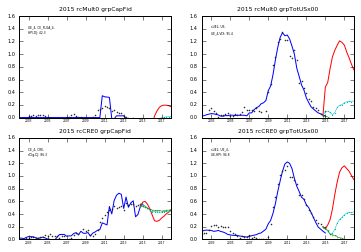

In [41]:
plt.rcParams.update({'font.size': 5})
xax = list(frt4b.index)
ccar = 2015

ver = 0     ## 0, 1, 2 only
for i in np.arange(4):
  plt.subplot(2, 2, i+1)
  if (i==0)|(i==2):
    frt4 = frt4b
    df4b = df4bc
    gtyp = 'grpCapFid'
  else:
    frt4 = frt4u
    df4b = df4bu
    gtyp = 'grpTotUSx00'

  if i<=1:
    j = 4
  else:
    j = 5

  plt.plot(xax,frt4[curlst[j]+str(ver),'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt4[curlst[j]+str(ver),'Fit'],ls='None', marker='o',c='w',ms=1,label='Fitted')
  plt.plot(xax,frt4[curlst[j]+str(ver),'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt4[curlst[j]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1,c='c',label='Adverse')
  plt.plot(xax,frt4[curlst[j]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1,label='Base')
  plt.annotate(df4b[df4b['rc']==curlst[j]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4b[df4b['rc']==curlst[j]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.82),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[j]+str(ver)+" "+gtyp)

  labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(0,1.6)

plt.savefig('grpCapFid_TotUS_Mult_CRE_ncofcst' +'.png', dpi=400, bbox_inches='tight')
plt.show()